# –ò–º–ø–æ—Ä—Ç –¥–∞–Ω–Ω—ã—Ö –∏ –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö

–î–∞—Ç–∞—Å–µ—Ç: https://www.kaggle.com/datasets/laotse/credit-risk-dataset?resource=download

In [ ]:
!pip install optuna

In [ ]:
# –°–∫—Ä—ã—Ç—å –ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏—è
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import os
import time
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import optuna

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [ ]:
# Download latest version
path = kagglehub.dataset_download("laotse/credit-risk-dataset")
print("–ü—É—Ç—å –∫ –¥–∞—Ç–∞—Å–µ—Ç—É:", path)

# –ü–æ–∫–∞–∑—ã–≤–∞–µ–º –≤—Å–µ —Ñ–∞–π–ª—ã
print("\n–§–∞–π–ª—ã –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ:")
files = os.listdir(path)
for f in files:
    print(f)

# –ü—Ä–æ–±—É–µ–º –ø—Ä–æ—á–∏—Ç–∞—Ç—å –ø–µ—Ä–≤—ã–π CSV-—Ñ–∞–π–ª
csv_files = [f for f in files if f.endswith('.csv')]
if csv_files:
    filename = csv_files[0]
    df = pd.read_csv(os.path.join(path, filename))
    print(f"\n–£—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω —Ñ–∞–π–ª: {filename}")

    # –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –Ω–∞–∑–≤–∞–Ω–∏–π —Å—Ç–æ–ª–±—Ü–æ–≤
    if df is not None:
        df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
        print("–°—Ç–æ–ª–±—Ü—ã –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω—ã.")
    else:
        print("–û—à–∏–±–∫–∞: df –Ω–µ –∑–∞–≥—Ä—É–∂–µ–Ω.")
else:
    print("CSV-—Ñ–∞–π–ª—ã –Ω–µ –Ω–∞–π–¥–µ–Ω—ã.")
    df = None

–ü—É—Ç—å –∫ –¥–∞—Ç–∞—Å–µ—Ç—É: /kaggle/input/credit-risk-dataset

–§–∞–π–ª—ã –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ:
credit_risk_dataset.csv

–£—Å–ø–µ—à–Ω–æ –∑–∞–≥—Ä—É–∂–µ–Ω —Ñ–∞–π–ª: credit_risk_dataset.csv
–°—Ç–æ–ª–±—Ü—ã –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω—ã.


In [ ]:
df.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

# –ü–µ—Ä–≤–∏—á–Ω–∞—è –æ—á–∏—Å—Ç–∫–∞

## –û–±—â–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞

### –†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞

In [ ]:
print(f"–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞: {df.shape}")

–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞: (32581, 12)


### –ü–µ—Ä–≤—ã–µ 5 —Å—Ç—Ä–æ–∫

In [ ]:
df.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

### –¢–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö

In [ ]:
# df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


**–í—ã–≤–æ–¥:**
1. –î–∞—Ç–∞—Å–µ—Ç —Å–æ–¥–µ—Ä–∂–∏—Ç 32571 —Å—Ç—Ä–æ–∫ –∏ 12 —Å—Ç–æ–ª–±—Ü–æ–≤
2. –ï—Å—Ç—å –∫–∞–∫ —á–∏—Å–ª–æ–≤—ã–µ (int, float), —Ç–∞–∫ –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ (object) –ø—Ä–∏–∑–Ω–∞–∫–∏.
3. –ü—Ä–∏–∑–Ω–∞–∫–∏ –≤–∫–ª—é—á–∞—é—Ç: –≤–æ–∑—Ä–∞—Å—Ç, –¥–æ—Ö–æ–¥, —Å—Ç–∞—Ç—É—Å –∫—Ä–µ–¥–∏—Ç–∞ –∏ —Ç.–¥.

## –ß–∏—Å–ª–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ

### –î—É–±–ª–∏–∫–∞—Ç—ã

In [ ]:
duplicates = df.duplicated().sum()
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: {duplicates}")

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: 165


In [ ]:
# –ü—Ä–æ—Å–º–æ—Ç—Ä —Ä–∞–∑–º–µ—Ä–∞ –¥–æ —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
print(f"–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞ –¥–æ —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: {df.shape}")

# –£–¥–∞–ª–µ–Ω–∏–µ –ø–æ–ª–Ω—ã—Ö –¥—É–±–ª–∏–∫–∞—Ç–æ–≤ (–ø–æ –≤—Å–µ–º —Å—Ç–æ–ª–±—Ü–∞–º)
df_cleaned = df.drop_duplicates()

# –ü—Ä–æ—Å–º–æ—Ç—Ä —Ä–∞–∑–º–µ—Ä–∞ –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è
print(f"–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: {df_cleaned.shape}")

–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞ –¥–æ —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: (32581, 12)
–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: (32416, 12)


### –ò—Å–ø—Ä–∞–≤–ª–µ–Ω–∏–µ —Ç–∏–ø–æ–≤ –¥–∞–Ω–Ω—ã—Ö

In [ ]:
data = df_cleaned.copy()

In [ ]:
data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map({'N': 0, 'Y': 1})

### –ü—Ä–æ—Å–º–æ—Ç—Ä —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤
–ï—Å–ª–∏ –µ—Å—Ç—å —É–¥–∞–ª–∏—Ç—å

In [ ]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

unique_df = data[numeric_cols].nunique().to_frame(name='Unique_Count')
unique_df['Total_Count'] = len(data)
unique_df['% Unique'] = (unique_df['Unique_Count'] / unique_df['Total_Count']) * 100

print(unique_df)

                            Unique_Count  Total_Count   % Unique
person_age                            58        32416   0.178924
person_income                       4295        32416  13.249630
person_emp_length                     36        32416   0.111056
loan_amnt                            753        32416   2.322927
loan_int_rate                        348        32416   1.073544
loan_status                            2        32416   0.006170
loan_percent_income                   77        32416   0.237537
cb_person_default_on_file              2        32416   0.006170
cb_person_cred_hist_length            29        32416   0.089462


### –ü–æ—Å–º–æ—Ç—Ä–µ—Ç—å –∫–∞–∫–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –Ω–µ–ø—Ä–µ—Ä—ã–≤–Ω—ã–µ, –∞ –∫–∞–∫–∏–µ –¥–∏—Å–∫—Ä–µ—Ç–Ω—ã–µ

In [ ]:
def classify_numeric_type(series, threshold=100):
    n_unique = series.nunique()
    if n_unique < threshold:
        return 'Discrete'
    else:
        return 'Continuous'

# –ü—Ä–∏–º–µ–Ω—è–µ–º
types = {}
for col in numeric_cols:
    types[col] = classify_numeric_type(data[col])

print("–¢–∏–ø—ã —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:")
print(pd.Series(types))

–¢–∏–ø—ã —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤:
person_age                      Discrete
person_income                 Continuous
person_emp_length               Discrete
loan_amnt                     Continuous
loan_int_rate                 Continuous
loan_status                     Discrete
loan_percent_income             Discrete
cb_person_default_on_file       Discrete
cb_person_cred_hist_length      Discrete
dtype: object


### –ö–∞–∫–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ —è–≤–ª—è—é—Ç—Å—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–º–∏

In [ ]:
# –ß–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏, –∫–æ—Ç–æ—Ä—ã–µ –ø–æ—á—Ç–∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ
almost_categorical = data[numeric_cols].nunique()[data[numeric_cols].nunique() < 20]

print("–ü–æ—á—Ç–∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏:")
print(almost_categorical)

–ü–æ—á—Ç–∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏:
loan_status                  2
cb_person_default_on_file    2
dtype: int64


## –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ

### –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –Ω–µ —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ

In [ ]:
data.memory_usage(deep=True).sum()  # object ‚Äî –º–Ω–æ–≥–æ

np.int64(7897405)

In [ ]:
# –ü—Ä–æ–≤–µ—Ä–∫–∞: –∫–∞–∫–∏–µ —Å—Ç–æ–ª–±—Ü—ã –Ω–µ —á–∏—Å–ª–æ–≤—ã–µ (object, string)
non_numeric_cols = data.select_dtypes(include=['object']).columns.tolist()

print("–ù–µ—á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –Ω–∞–π–¥–µ–Ω—ã:")
print(non_numeric_cols)

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Å–µ –Ω–µ—á–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã –≤ 'category'
data[non_numeric_cols] = data[non_numeric_cols].astype('category')

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
print("\n–¢–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö –ø–æ—Å–ª–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è:")
print(data.dtypes)

–ù–µ—á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –Ω–∞–π–¥–µ–Ω—ã:
['person_home_ownership', 'loan_intent', 'loan_grade']

–¢–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö –ø–æ—Å–ª–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è:
person_age                       int64
person_income                    int64
person_home_ownership         category
person_emp_length              float64
loan_intent                   category
loan_grade                    category
loan_amnt                        int64
loan_int_rate                  float64
loan_status                      int64
loan_percent_income            float64
cb_person_default_on_file        int64
cb_person_cred_hist_length       int64
dtype: object


In [ ]:
data.memory_usage(deep=True).sum()  # category ‚Äî –≤ —Ä–∞–∑—ã –º–µ–Ω—å—à–µ

np.int64(2692095)

### –ò—Å–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –æ–ø–µ—á–∞—Ç–æ–∫ –∏ –Ω–µ—Å–æ–≥–ª–∞—Å–æ–≤–∞–Ω–Ω–æ—Å—Ç–∏

In [ ]:
# –ü–æ–ª—É—á–∞–µ–º —Å–ø–∏—Å–æ–∫ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤
categorical_cols = data.select_dtypes(include=['category', 'object']).columns.tolist()

print("–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏:", categorical_cols)

–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏: ['person_home_ownership', 'loan_intent', 'loan_grade']


In [ ]:
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(data[col].value_counts())


--- person_home_ownership ---
person_home_ownership
RENT        16378
MORTGAGE    13369
OWN          2563
OTHER         106
Name: count, dtype: int64

--- loan_intent ---
loan_intent
EDUCATION            6411
MEDICAL              6042
VENTURE              5682
PERSONAL             5498
DEBTCONSOLIDATION    5189
HOMEIMPROVEMENT      3594
Name: count, dtype: int64

--- loan_grade ---
loan_grade
A    10703
B    10387
C     6438
D     3620
E      963
F      241
G       64
Name: count, dtype: int64


**–í—ã–≤–æ–¥:**
1. –ü—Ä–æ–≤–µ–ª –ø–µ—Ä—á–∏–Ω—É—é –æ—á–∏—Å—Ç–∫—É –¥–∞–Ω–Ω—ã—Ö
2. –ü—Ä–æ—Å–º–æ—Ç—Ä–µ–ª –æ–±—â—É—é —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É
3. –ü–æ—Ä–∞–±–æ—Ç–∞–ª —Å —á–∏—Å–ª–æ–≤—ã–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏
4. –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–ª –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –≤ category –¥–ª—è —ç–∫–æ–Ω–æ–º–∏—è –ø–∞–º—è—Ç–∏

# –ü–µ—Ä–≤–∏—á–Ω—ã–π EDA

## –ê–Ω–∞–ª–∏–∑ –ø—Ä–æ–ø—É—Å–∫–æ–≤

In [ ]:
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    '–ü—Ä–æ–ø—É—Å–∫–∏': missing,
    '–ü—Ä–æ—Ü–µ–Ω—Ç': missing_percent.round(2)
})
missing_df

–ü—Ä–æ–ø—É—Å–∫–∏  –ü—Ä–æ—Ü–µ–Ω—Ç
person_age                         0     0.00
person_income                      0     0.00
person_home_ownership              0     0.00
person_emp_length                887     2.74
loan_intent                        0     0.00
loan_grade                         0     0.00
loan_amnt                          0     0.00
loan_int_rate                   3095     9.55
loan_status                        0     0.00
loan_percent_income                0     0.00
cb_person_default_on_file          0     0.00
cb_person_cred_hist_length         0     0.00

                   –ü—Ä–æ–ø—É—Å–∫–∏  –ü—Ä–æ—Ü–µ–Ω—Ç
person_emp_length       887     2.74
loan_int_rate          3095     9.55


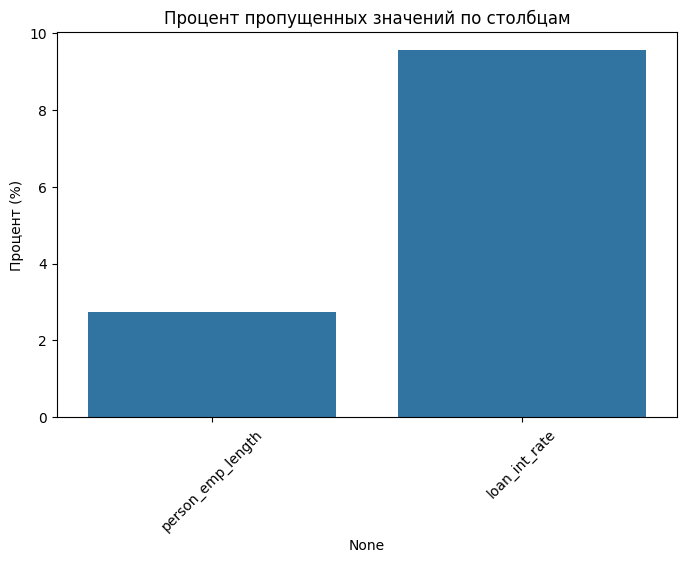

In [ ]:
missing_df = missing_df[missing_df['–ü—Ä–æ–ø—É—Å–∫–∏'] > 0]

if missing_df.empty:
    print("‚ùå –ü—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –Ω–µ—Ç.")
else:
    print(missing_df)
    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
    plt.figure(figsize=(8, 5))
    sns.barplot(x=missing_df.index, y=missing_df['–ü—Ä–æ—Ü–µ–Ω—Ç'])
    plt.title("–ü—Ä–æ—Ü–µ–Ω—Ç –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ —Å—Ç–æ–ª–±—Ü–∞–º")
    plt.ylabel("–ü—Ä–æ—Ü–µ–Ω—Ç (%)")
    plt.xticks(rotation=45)
    plt.show()

## –ü–æ–∏—Å–∫ –≤—ã–±—Ä–æ—Å–æ–≤ (IQR)

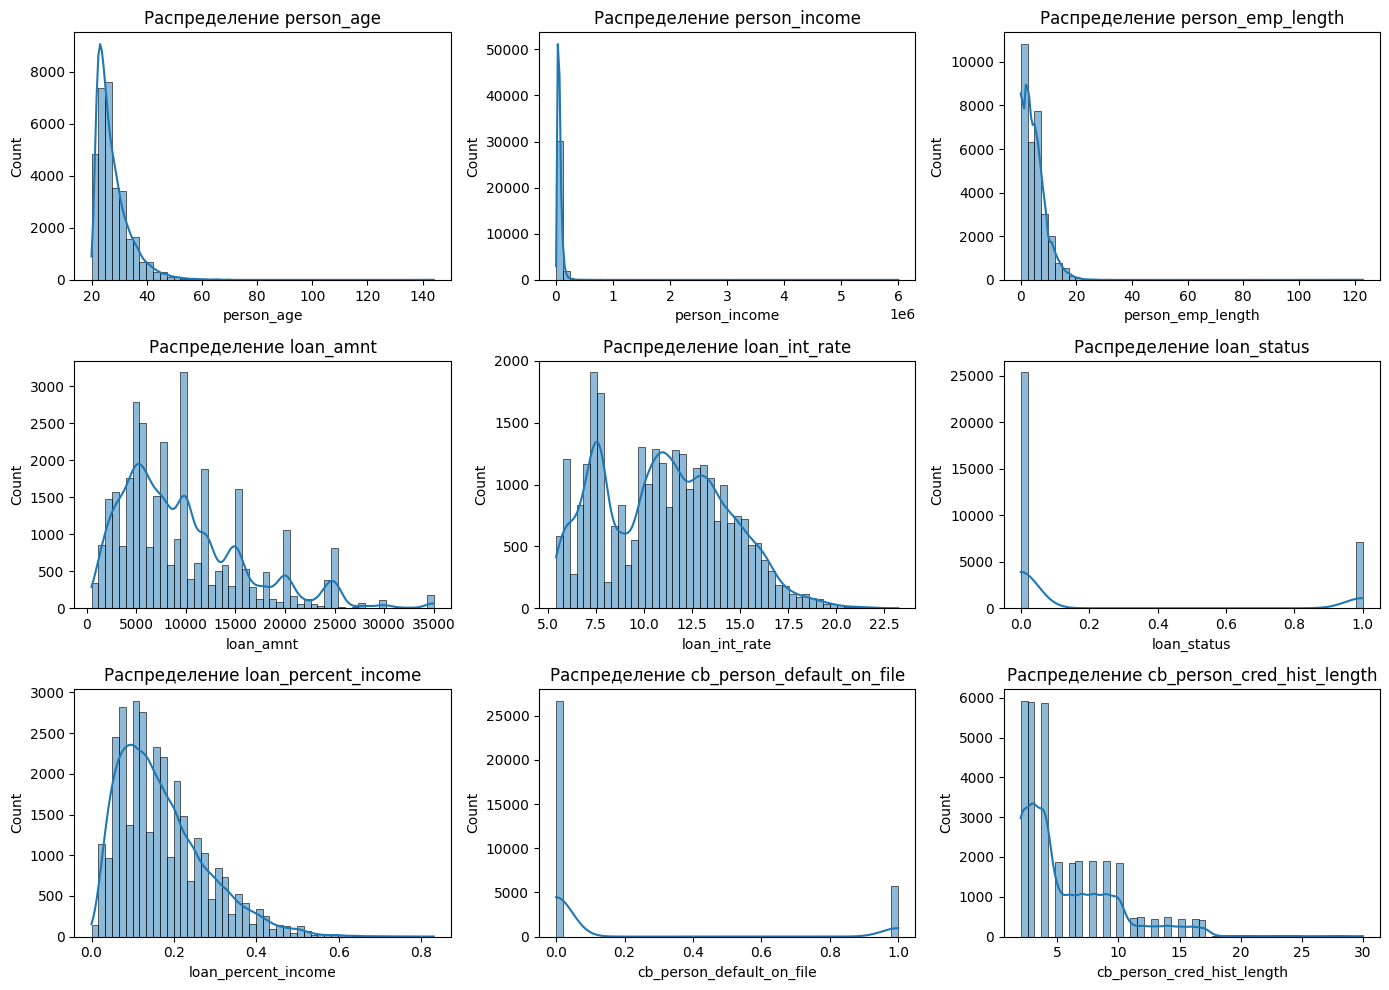

In [ ]:
plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col].dropna(), bins=50, kde=True)
    plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [ ]:
def detect_outliers_iqr(series):
    if not np.issubdtype(series.dtype, np.number):
        raise TypeError("–î–∞–Ω–Ω—ã–µ –¥–æ–ª–∂–Ω—ã –±—ã—Ç—å —á–∏—Å–ª–æ–≤—ã–º–∏")

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

print("–ê–Ω–∞–ª–∏–∑ –≤—ã–±—Ä–æ—Å–æ–≤ (–±–µ–∑ –æ–±—Ä–∞–±–æ—Ç–∫–∏ –ø—Ä–æ–ø—É—Å–∫–æ–≤):")
print("="*60)

for col in numeric_cols:
    clean_data = data[col].dropna()
    if len(clean_data) == 0:
        continue

    try:
        outliers, low, high = detect_outliers_iqr(clean_data)
        percentage = len(outliers) / len(clean_data) * 100
        print(f"{col:25} | {len(outliers):4} –≤—ã–±—Ä–æ—Å–æ–≤ | {percentage:5.2f}% | ({low:.2f}, {high:.2f})")
    except Exception as e:
        print(f"{col:25} | –û—à–∏–±–∫–∞: {e}")

–ê–Ω–∞–ª–∏–∑ –≤—ã–±—Ä–æ—Å–æ–≤ (–±–µ–∑ –æ–±—Ä–∞–±–æ—Ç–∫–∏ –ø—Ä–æ–ø—É—Å–∫–æ–≤):
person_age                | 1491 –≤—ã–±—Ä–æ—Å–æ–≤ |  4.60% | (12.50, 40.50)
person_income             | 1478 –≤—ã–±—Ä–æ—Å–æ–≤ |  4.56% | (-22472.00, 140232.00)
person_emp_length         |  852 –≤—ã–±—Ä–æ—Å–æ–≤ |  2.70% | (-5.50, 14.50)
loan_amnt                 | 1679 –≤—ã–±—Ä–æ—Å–æ–≤ |  5.18% | (-5875.00, 23125.00)
loan_int_rate             |    6 –≤—ã–±—Ä–æ—Å–æ–≤ |  0.02% | (-0.46, 21.83)
loan_status               | 7089 –≤—ã–±—Ä–æ—Å–æ–≤ | 21.87% | (0.00, 0.00)
loan_percent_income       |  650 –≤—ã–±—Ä–æ—Å–æ–≤ |  2.01% | (-0.12, 0.44)
cb_person_default_on_file | 5730 –≤—ã–±—Ä–æ—Å–æ–≤ | 17.68% | (0.00, 0.00)
cb_person_cred_hist_length | 1139 –≤—ã–±—Ä–æ—Å–æ–≤ |  3.51% | (-4.50, 15.50)


**–í—ã–≤–æ–¥:**
- PERSON_AGE:  –≤–æ–∑—Ä–∞—Å—Ç 144 - —ç—Ç–æ —è–≤–Ω–æ –≤—ã–±—Ä–æ—Å
- PERSON_EMP_LENGTH: –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å —Ç—Ä—É–¥–æ–≤–æ–π –¥–µ—è—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å 123


In [ ]:
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    '–ü—Ä–æ–ø—É—Å–∫–∏': missing,
    '–ü—Ä–æ—Ü–µ–Ω—Ç': missing_percent.round(2)
})
missing_df

–ü—Ä–æ–ø—É—Å–∫–∏  –ü—Ä–æ—Ü–µ–Ω—Ç
person_age                         0     0.00
person_income                      0     0.00
person_home_ownership              0     0.00
person_emp_length                887     2.74
loan_intent                        0     0.00
loan_grade                         0     0.00
loan_amnt                          0     0.00
loan_int_rate                   3095     9.55
loan_status                        0     0.00
loan_percent_income                0     0.00
cb_person_default_on_file          0     0.00
cb_person_cred_hist_length         0     0.00

## –ê–Ω–∞–ª–∏–∑ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π

### –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤

In [ ]:
target = 'loan_status'

In [ ]:
—Ålass_distribution = data[target].value_counts()
print("\n–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:")
print(—Ålass_distribution)

# –ü—Ä–æ—Ü–µ–Ω—Ç–Ω–æ–µ —Å–æ–æ—Ç–Ω–æ—à–µ–Ω–∏–µ
print("\n–ü—Ä–æ—Ü–µ–Ω—Ç—ã:")
print(data[target].value_counts(normalize=True) * 100)


–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:
loan_status
0    25327
1     7089
Name: count, dtype: int64

–ü—Ä–æ—Ü–µ–Ω—Ç—ã:
loan_status
0    78.13117
1    21.86883
Name: proportion, dtype: float64


### –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è

In [ ]:
# plt.figure(figsize=(8, 6))
# sns.countplot(data=data, x=target)
# plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤: {target}')
# plt.xlabel('–ö–ª–∞—Å—Å')
# plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ')
# plt.xticks(ticks=[0, 1], labels=['Non-default (0)', 'Default (1)'])
# plt.show()

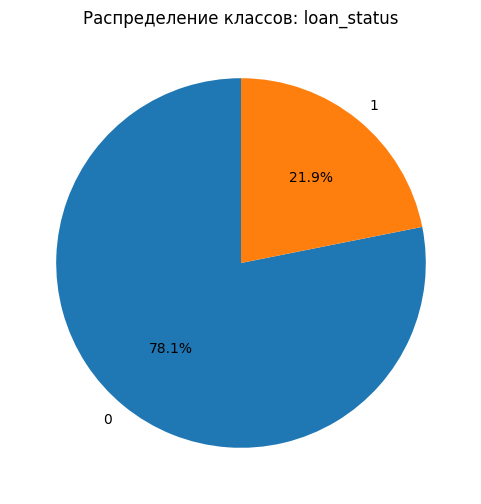

In [ ]:
plt.figure(figsize=(6, 6))
data[target].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤: {target}')
plt.ylabel('')
plt.show()

### –ë–∞–ª–∞–Ω—Å / –î–∏—Å–±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤

–ï—Å–ª–∏ –æ–¥–∏–Ω –∫–ª–∞—Å—Å —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç –º–µ–Ω–µ–µ 10‚Äì20% ‚Äî —Å—á–∏—Ç–∞–µ—Ç—Å—è –¥–∏—Å–±–∞–ª–∞–Ω—Å–æ–º.

(–¥–µ—Ñ–æ–ª—Ç) = 21% ‚Üí —ç—Ç–æ –ª–µ–≥–∫–∏–π –¥–∏—Å–±–∞–ª–∞–Ω—Å, –ø–æ—ç—Ç–æ–º—É —Å—Ç–æ–∏—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å —Ä–∞–∑–ª–∏—á–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏ –∏ –Ω–µ–æ–ø–∏—Ä–∞—Ç—å—Å—è –Ω–∞ Accuracy

## –û–¥–Ω–æ–º–µ—Ä–Ω—ã–π –∞–Ω–∞–ª–∏–∑

In [ ]:
# –†–∞–∑–¥–µ–ª–∏–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –Ω–∞ —á–∏—Å–ª–æ–≤—ã–µ –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['category']).columns.tolist()


print(f"–ß–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏: {numeric_cols}")
print(f"–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏: {categorical_cols}")

–ß–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
–ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏: ['person_home_ownership', 'loan_intent', 'loan_grade']


### –ê–Ω–∞–ª–∏–∑ –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤


üîç –ü—Ä–∏–∑–Ω–∞–∫: person_age
–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:
count    32581.000000
mean        27.734600
std          6.348078
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64


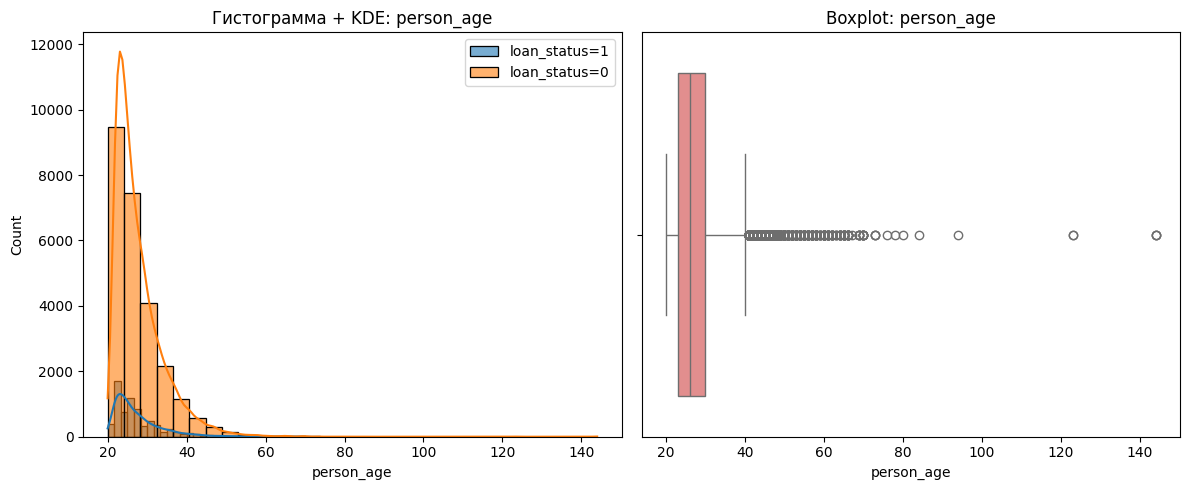


üîç –ü—Ä–∏–∑–Ω–∞–∫: person_income
–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:
count    3.258100e+04
mean     6.607485e+04
std      6.198312e+04
min      4.000000e+03
25%      3.850000e+04
50%      5.500000e+04
75%      7.920000e+04
max      6.000000e+06
Name: person_income, dtype: float64


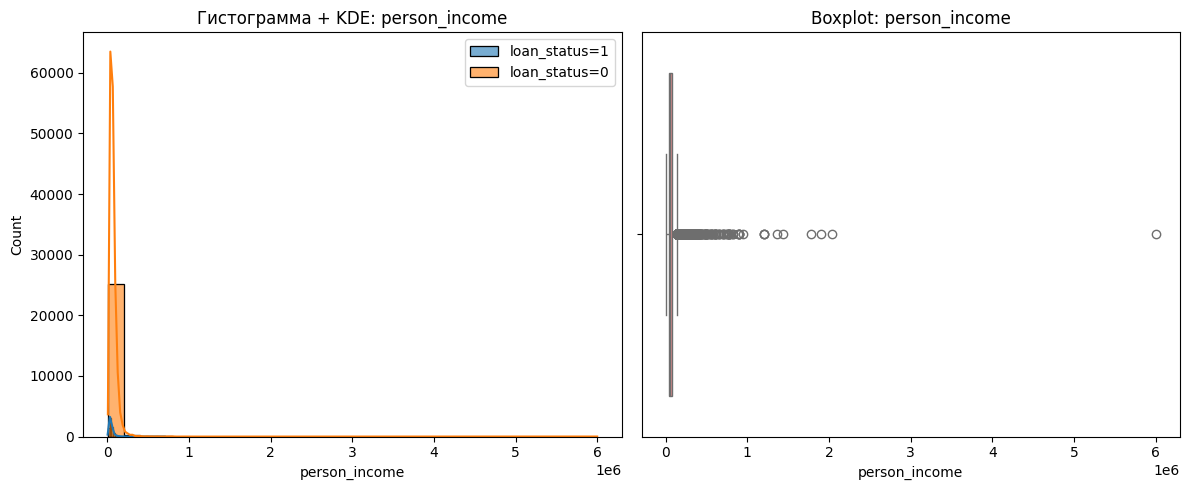


üîç –ü—Ä–∏–∑–Ω–∞–∫: person_emp_length
–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:
count    31686.000000
mean         4.789686
std          4.142630
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64


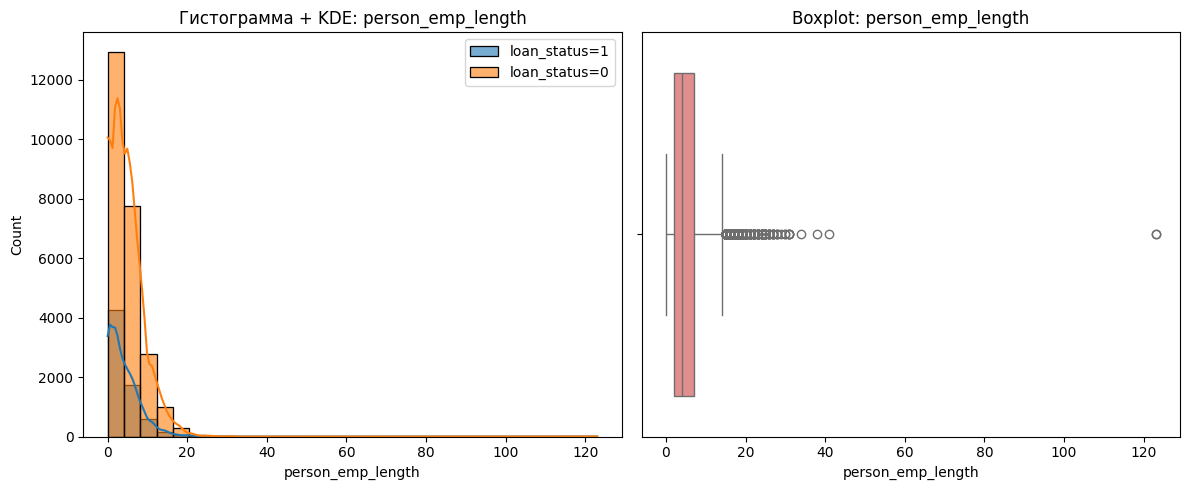


üîç –ü—Ä–∏–∑–Ω–∞–∫: loan_amnt
–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:
count    32581.000000
mean      9589.371106
std       6322.086646
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12200.000000
max      35000.000000
Name: loan_amnt, dtype: float64


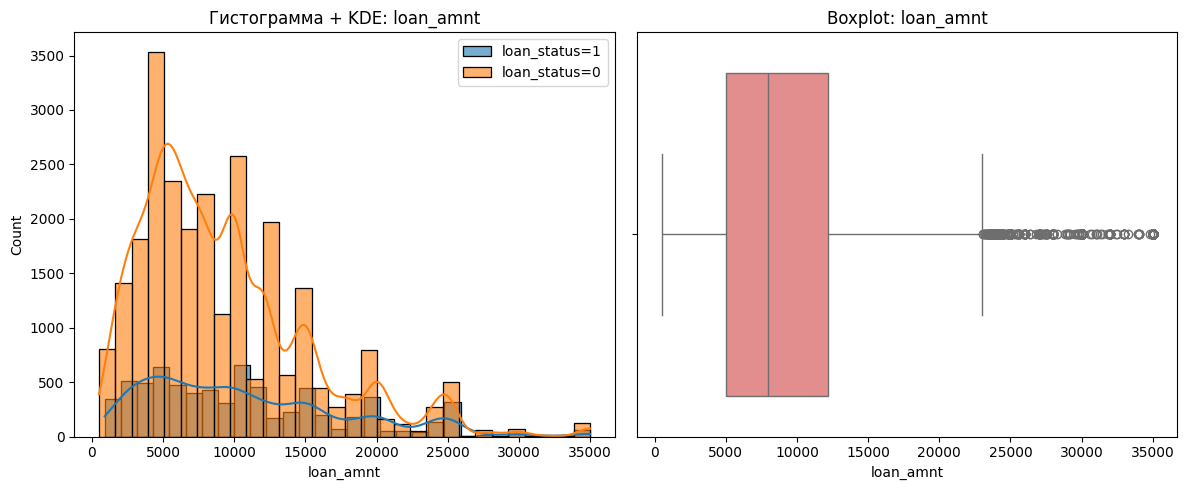


üîç –ü—Ä–∏–∑–Ω–∞–∫: loan_int_rate
–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:
count    29465.000000
mean        11.011695
std          3.240459
min          5.420000
25%          7.900000
50%         10.990000
75%         13.470000
max         23.220000
Name: loan_int_rate, dtype: float64


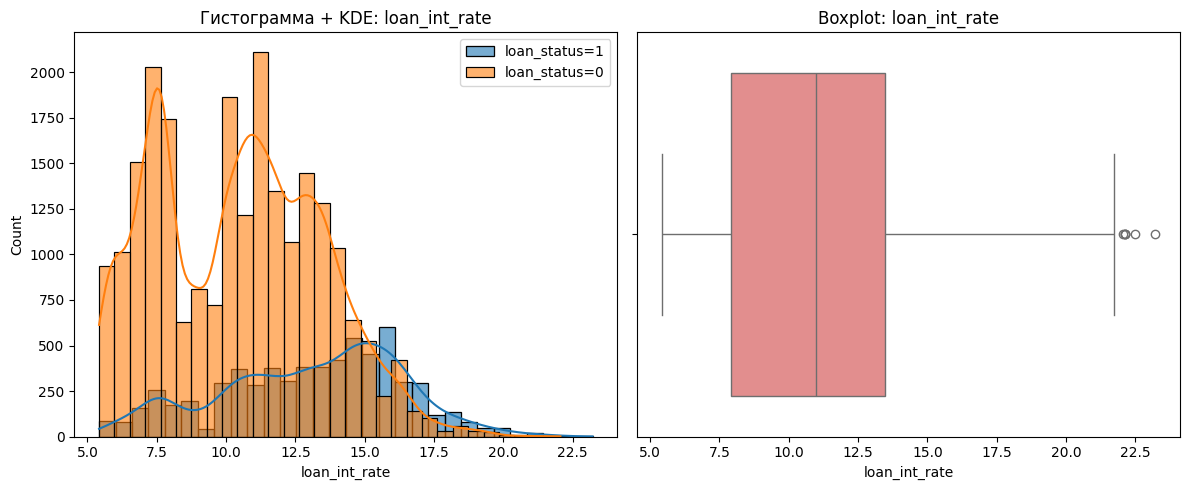


üîç –ü—Ä–∏–∑–Ω–∞–∫: loan_status
–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:
count    32581.000000
mean         0.218164
std          0.413006
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64


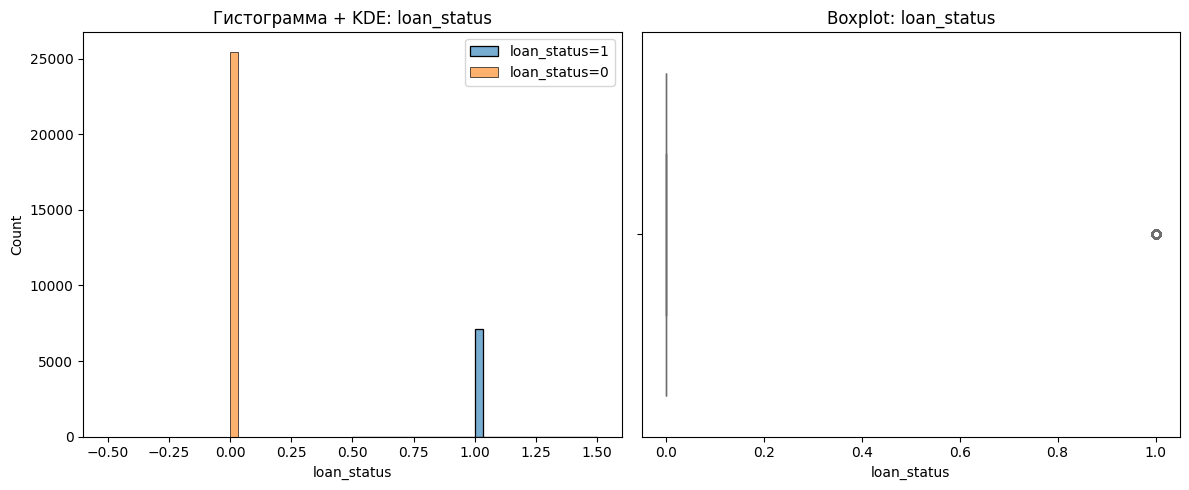


üîç –ü—Ä–∏–∑–Ω–∞–∫: loan_percent_income
–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:
count    32581.000000
mean         0.170203
std          0.106782
min          0.000000
25%          0.090000
50%          0.150000
75%          0.230000
max          0.830000
Name: loan_percent_income, dtype: float64


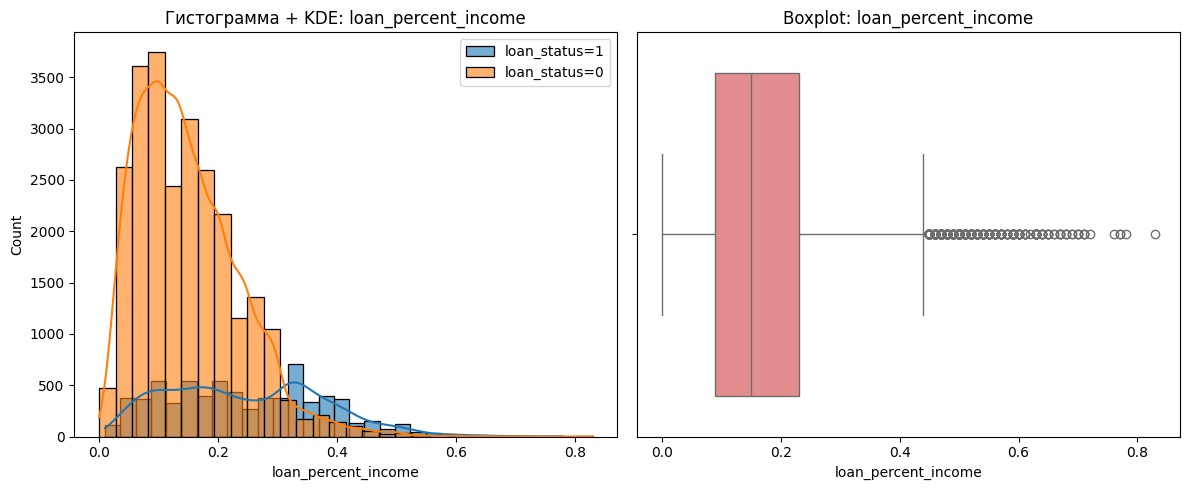


üîç –ü—Ä–∏–∑–Ω–∞–∫: cb_person_default_on_file
–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:
count     32581
unique        2
top           N
freq      26836
Name: cb_person_default_on_file, dtype: object


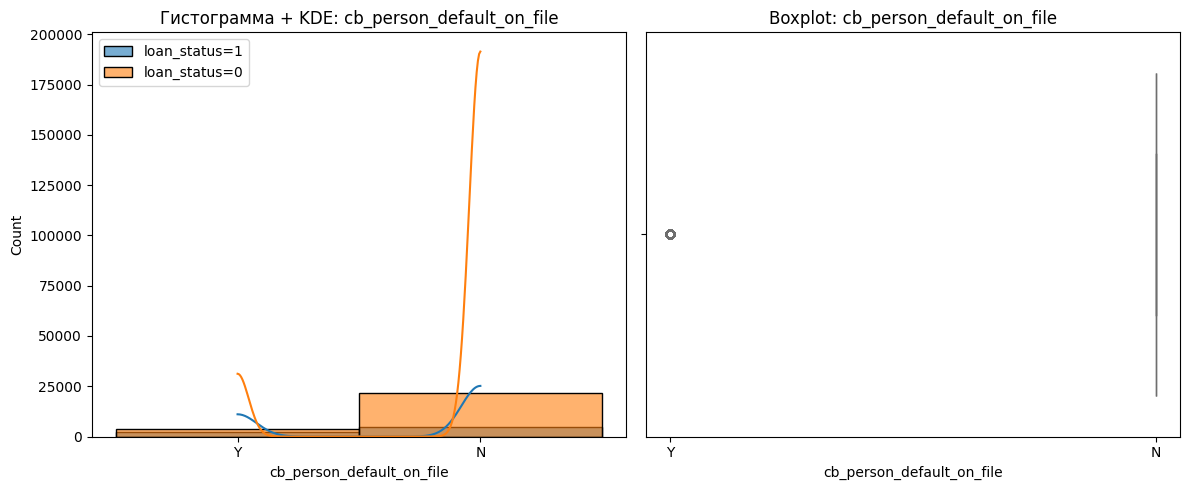


üîç –ü—Ä–∏–∑–Ω–∞–∫: cb_person_cred_hist_length
–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:
count    32581.000000
mean         5.804211
std          4.055001
min          2.000000
25%          3.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: cb_person_cred_hist_length, dtype: float64


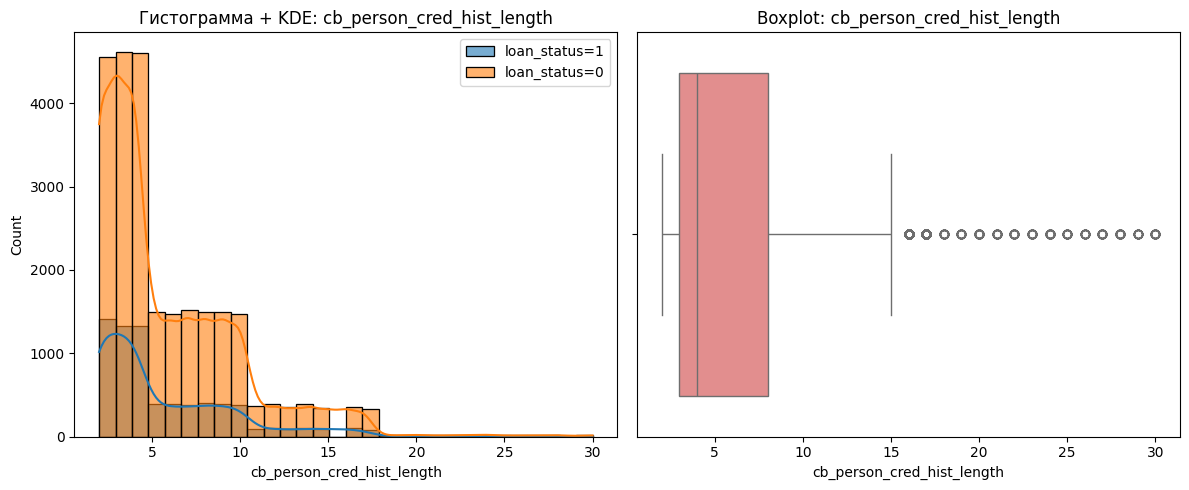

In [ ]:
for col in numeric_cols:
    print(f"\nüîç –ü—Ä–∏–∑–Ω–∞–∫: {col}")

    # df.describe()
    print(f"–û–ø–∏—Å–∞—Ç–µ–ª—å–Ω–∞—è —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞:")
    print(df[col].describe())

    # –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ + –ø–ª–æ—Ç–Ω–æ—Å—Ç—å
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for cls in df[target].unique():
        subset = df[df[target] == cls]
        sns.histplot(subset[col], bins=30, kde=True, label=f'{target}={cls}', alpha=0.6)
    plt.legend()
    plt.title(f'–ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ + KDE: {col}')
    plt.xlabel(col)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='lightcoral')
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

**–í—ã–≤–æ–¥:**
–í—Å–µ —á–∏—Å–ª–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ –∏–º–µ—é—Ç –∞—Å—Å–∏–º–µ—Ç—Ä–∏—á–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ

### –ê–Ω–∞–ª–∏–∑ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤


üîç –ü—Ä–∏–∑–Ω–∞–∫: person_home_ownership
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π:
person_home_ownership
RENT        50.477272
MORTGAGE    41.263313
OWN          7.931003
OTHER        0.328412
Name: proportion, dtype: float64

–û–ø–∏—Å–∞–Ω–∏–µ:
count     32581
unique        4
top        RENT
freq      16446
Name: person_home_ownership, dtype: object


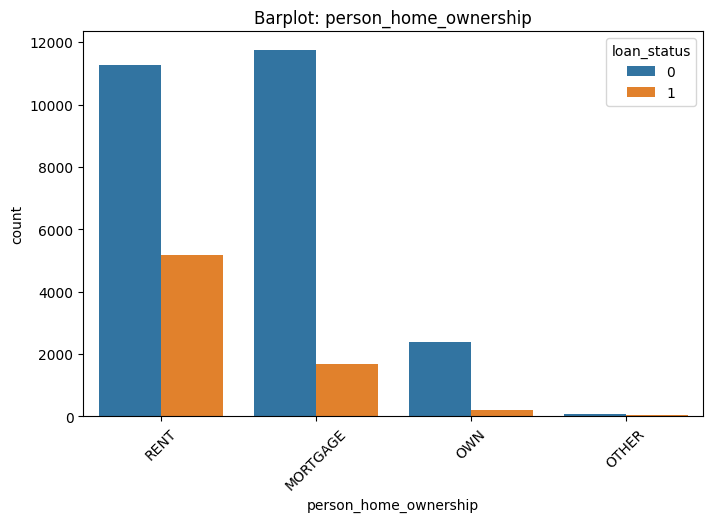


üîç –ü—Ä–∏–∑–Ω–∞–∫: loan_intent
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π:
loan_intent
EDUCATION            19.806022
MEDICAL              18.633559
VENTURE              17.553175
PERSONAL             16.945459
DEBTCONSOLIDATION    15.997053
HOMEIMPROVEMENT      11.064731
Name: proportion, dtype: float64

–û–ø–∏—Å–∞–Ω–∏–µ:
count         32581
unique            6
top       EDUCATION
freq           6453
Name: loan_intent, dtype: object


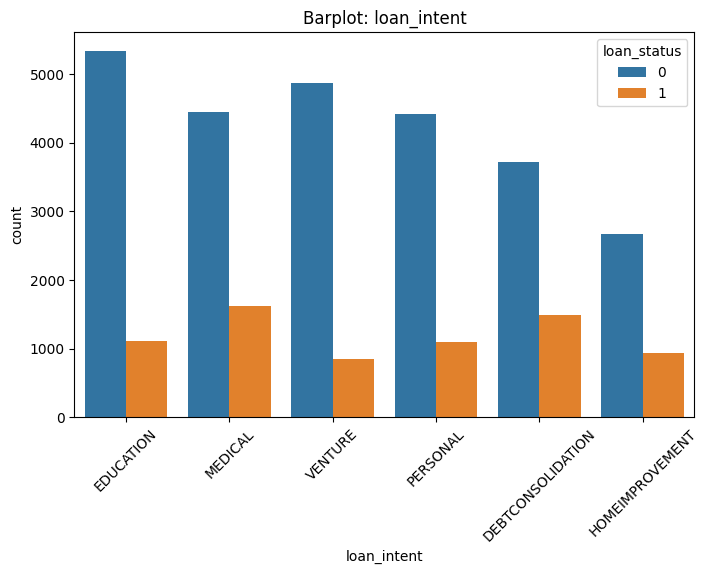


üîç –ü—Ä–∏–∑–Ω–∞–∫: loan_grade
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è: ['D' 'B' 'C' 'A' 'E' 'F' 'G']
–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π:
loan_grade
A    33.077561
B    32.076977
C    19.821368
D    11.129186
E     2.958780
F     0.739695
G     0.196434
Name: proportion, dtype: float64

–û–ø–∏—Å–∞–Ω–∏–µ:
count     32581
unique        7
top           A
freq      10777
Name: loan_grade, dtype: object


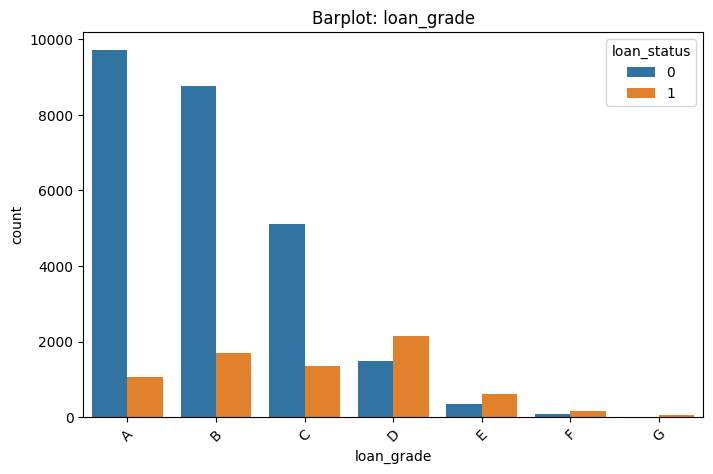

In [ ]:
for col in categorical_cols:
    print(f"\nüîç –ü—Ä–∏–∑–Ω–∞–∫: {col}")

    # .unique() –∏ .value_counts()
    unique_values = df[col].unique()
    value_counts = df[col].value_counts(normalize=True) * 100

    print(f"–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è: {unique_values}")
    print(f"–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π:\n{value_counts}")

    # df.describe()
    print(f"\n–û–ø–∏—Å–∞–Ω–∏–µ:")
    print(df[col].describe())

    # Barplot
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, hue=target, order=value_counts.index)
    plt.title(f'Barplot: {col}')
    plt.xticks(rotation=45)
    plt.show()

**–í—ã–≤–æ–¥:**
person_home_ownership: –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ –ª—é–¥–µ–π –∞—Ä–µ–Ω–¥—É—é—Ç –∂–∏—Ç—å–µ –∏–ª–∏ —É –Ω–∏—Ö –∏–ø–æ—Ç–µ–∫–∞. OTHER ‚Äî –º–æ–∂–Ω–æ —É–¥–∞–ª–∏—Ç—å
loan_intent: –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ –∫—Ä–µ–¥–∏—Ç–æ–≤ –æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ, –º–µ–¥–∏—Ü–∏–Ω–∞, –±–∏–∑–Ω–µ—Å
loan_grade: –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ –ª—é–¥–µ–π –∏–º–µ—é—Ç —Ö–æ—Ä–æ—à–∏–π —Ä–µ–π—Ç–∏–Ω–≥. –û–±—ä–µ–¥–∏–Ω–∏—Ç—å —Ä–µ–¥–∫–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏: F, G ‚Üí HIGH_RISK
cb_person_default_on_file: –≤ –¥–∞–Ω–Ω–æ–º –ø—Ä–∏–∑–Ω–∞–∫–µ –∏–º–µ–µ—Ç –¥–∏—Å–±–∞–ª–∞–Ω—Å –ø—Ä–æ–ø–æ—Ä—Ü–∏–∏. –ú–æ–¥–µ–ª—å –¥–æ–ª–∂–Ω–∞ —Å–∏–ª—å–Ω–µ–µ –≤–∑–≤–µ—à–∏–≤–∞—Ç—å —ç—Ç–æ—Ç –ø—Ä–∏–∑–Ω–∞–∫. –õ—é–¥–∏ —Å –∏—Å—Ç–æ—Ä–∏–µ–π –ø—Ä–æ—Å—Ä–æ—á–µ–∫ ‚Äî –≤—ã—Å–æ–∫–∏–π —Ä–∏—Å–∫

OneHotEncoder:

- person_home_ownership ('RENT' 'OWN' 'MORTGAGE' 'OTHER')

- loan_intent ('PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
'DEBTCONSOLIDATION')

LabelEncoder:
- loan_grade ('D' 'B' 'C' 'A' 'E' 'F' 'G')


## –î–≤—É–º–µ—Ä–Ω—ã–π –∞–Ω–∞–ª–∏–∑

### –ü—Ä–∏–∑–Ω–∞–∫ —á–∏—Å–ª–æ–≤–æ–π –∏ –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è (–î–≤–∞ —á–∏—Å–ª–æ–≤—ã—Ö)

In [ ]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    '–ü—Ä–æ–ø—É—Å–∫–∏': missing,
    '–ü—Ä–æ—Ü–µ–Ω—Ç': missing_percent.round(2)
})
missing_df

–ü—Ä–æ–ø—É—Å–∫–∏  –ü—Ä–æ—Ü–µ–Ω—Ç
person_age                         0     0.00
person_income                      0     0.00
person_home_ownership              0     0.00
person_emp_length                895     2.75
loan_intent                        0     0.00
loan_grade                         0     0.00
loan_amnt                          0     0.00
loan_int_rate                   3116     9.56
loan_status                        0     0.00
loan_percent_income                0     0.00
cb_person_default_on_file          0     0.00
cb_person_cred_hist_length         0     0.00

In [ ]:
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    '–ü—Ä–æ–ø—É—Å–∫–∏': missing,
    '–ü—Ä–æ—Ü–µ–Ω—Ç': missing_percent.round(2)
})
missing_df

–ü—Ä–æ–ø—É—Å–∫–∏  –ü—Ä–æ—Ü–µ–Ω—Ç
person_age                         0     0.00
person_income                      0     0.00
person_home_ownership              0     0.00
person_emp_length                887     2.74
loan_intent                        0     0.00
loan_grade                         0     0.00
loan_amnt                          0     0.00
loan_int_rate                   3095     9.55
loan_status                        0     0.00
loan_percent_income                0     0.00
cb_person_default_on_file          0     0.00
cb_person_cred_hist_length         0     0.00

In [ ]:
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32416 non-null  int64   
 1   person_income               32416 non-null  int64   
 2   person_home_ownership       32416 non-null  category
 3   person_emp_length           31529 non-null  float64 
 4   loan_intent                 32416 non-null  category
 5   loan_grade                  32416 non-null  category
 6   loan_amnt                   32416 non-null  int64   
 7   loan_int_rate               29321 non-null  float64 
 8   loan_status                 32416 non-null  int64   
 9   loan_percent_income         32416 non-null  float64 
 10  cb_person_default_on_file   32416 non-null  int64   
 11  cb_person_cred_hist_length  32416 non-null  int64   
dtypes: category(3), float64(3), int64(6)
memory usage: 2.6 MB


In [ ]:
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    '–ü—Ä–æ–ø—É—Å–∫–∏': missing,
    '–ü—Ä–æ—Ü–µ–Ω—Ç': missing_percent.round(2)
})
missing_df

–ü—Ä–æ–ø—É—Å–∫–∏  –ü—Ä–æ—Ü–µ–Ω—Ç
person_age                         0     0.00
person_income                      0     0.00
person_home_ownership              0     0.00
person_emp_length                887     2.74
loan_intent                        0     0.00
loan_grade                         0     0.00
loan_amnt                          0     0.00
loan_int_rate                   3095     9.55
loan_status                        0     0.00
loan_percent_income                0     0.00
cb_person_default_on_file          0     0.00
cb_person_cred_hist_length         0     0.00

In [ ]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    '–ü—Ä–æ–ø—É—Å–∫–∏': missing,
    '–ü—Ä–æ—Ü–µ–Ω—Ç': missing_percent.round(2)
})
missing_df

–ü—Ä–æ–ø—É—Å–∫–∏  –ü—Ä–æ—Ü–µ–Ω—Ç
person_age                         0     0.00
person_income                      0     0.00
person_home_ownership              0     0.00
person_emp_length                887     2.74
loan_intent                        0     0.00
loan_grade                         0     0.00
loan_amnt                          0     0.00
loan_int_rate                   3095     9.55
loan_status                        0     0.00
loan_percent_income                0     0.00
cb_person_default_on_file          0     0.00
cb_person_cred_hist_length         0     0.00

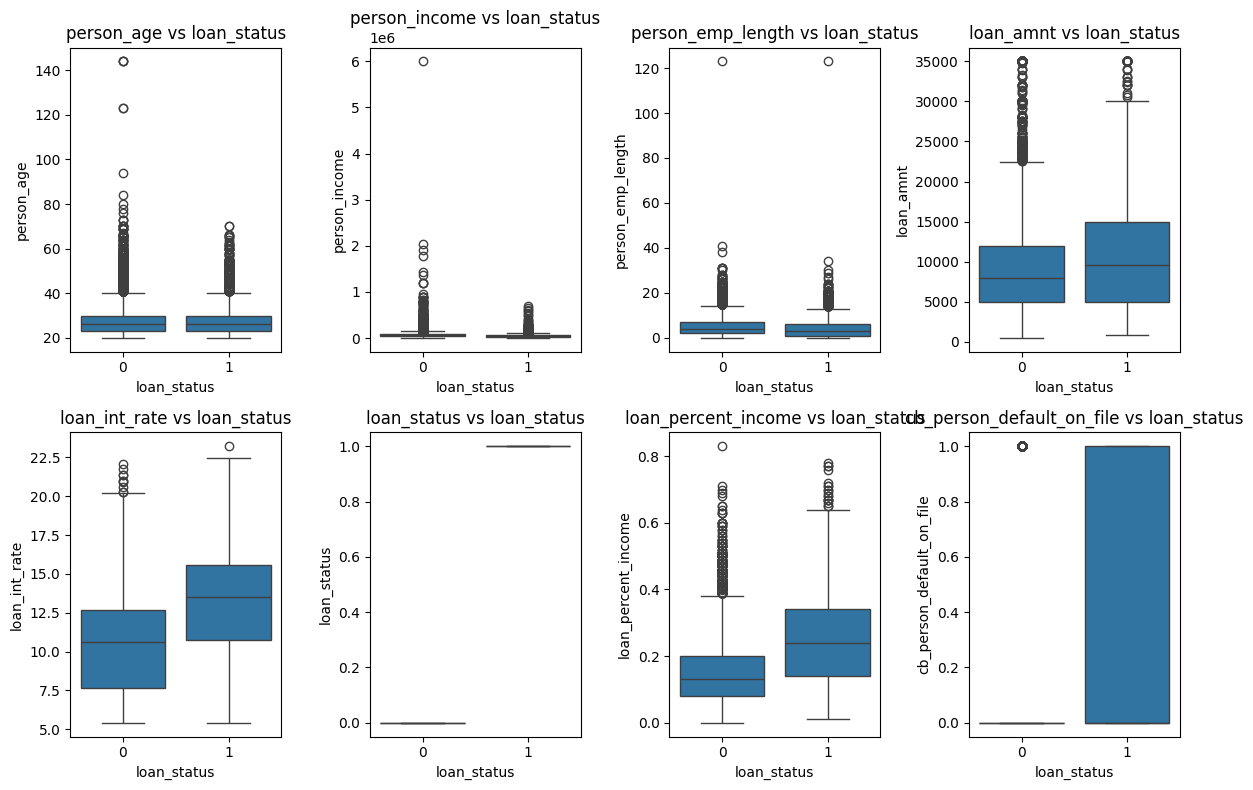

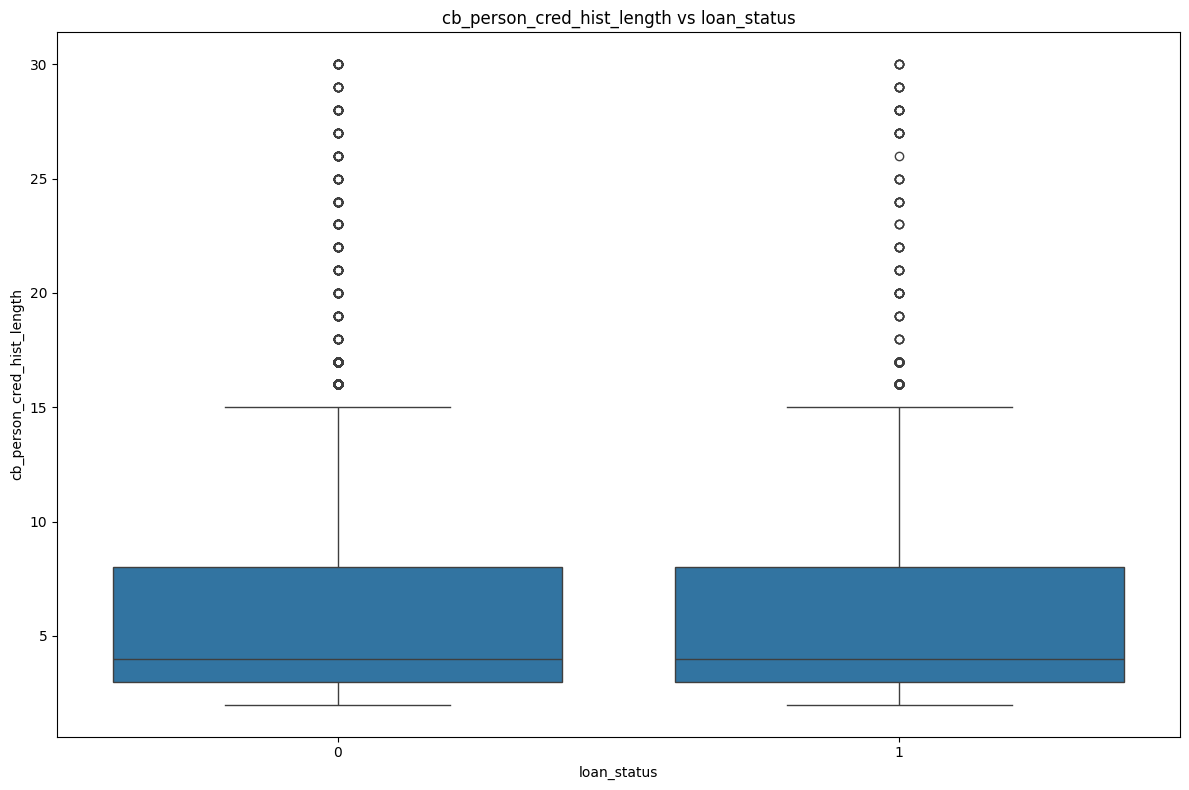

In [ ]:
# –ü–µ—Ä–≤–∞—è —á–∞—Å—Ç—å: –ø–µ—Ä–≤—ã–µ 8 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols[:8], 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=df, x=target, y=col)
    # sns.stripplot(x=target, y=col, data=df)
    plt.title(f'{col} vs {target}')
plt.tight_layout()
plt.show()

# –í—Ç–æ—Ä–∞—è —á–∞—Å—Ç—å: –æ—Å—Ç–∞–≤—à–∏–µ—Å—è
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols[8:], 1):
    plt.subplot(1, 1, i)
    sns.boxplot(data=df, x=target, y=col)
    # sns.stripplot(x=target, y=col, data=df)
    plt.title(f'{col} vs {target}')
plt.tight_layout()
plt.show()

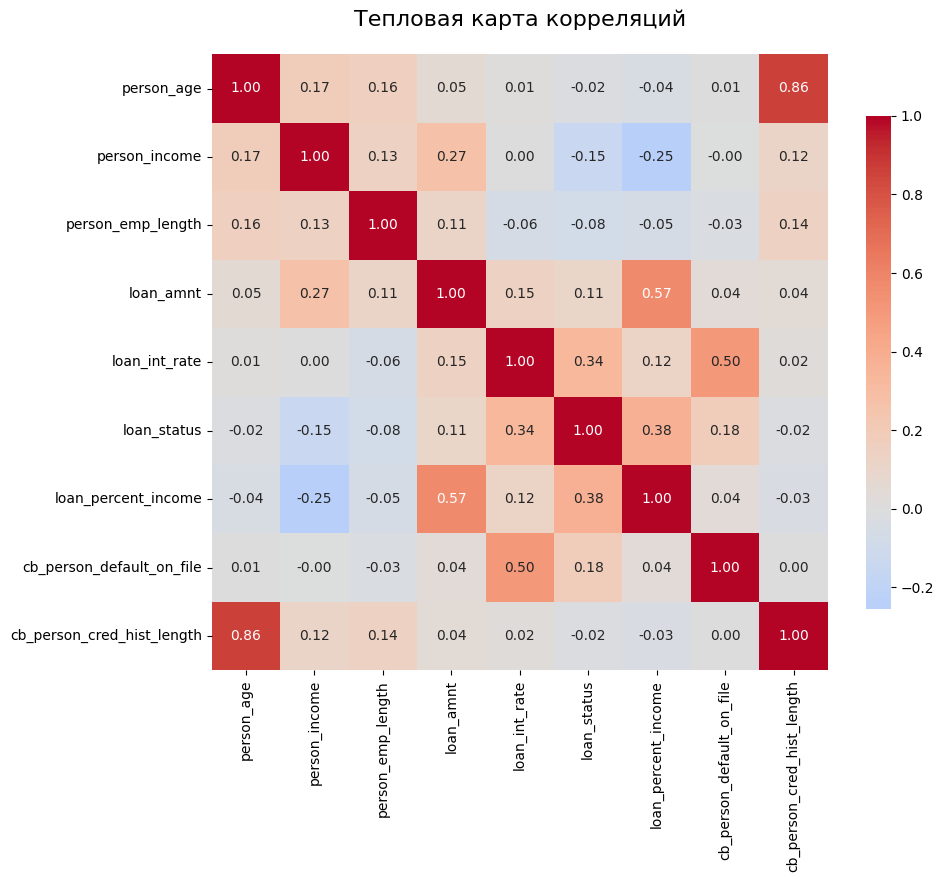

In [ ]:
df_numeric = df[numeric_cols]

# –ú–∞—Ç—Ä–∏—Ü–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π
corr_matrix = df_numeric.corr()

# –¢–µ–ø–ª–æ–≤–∞—è –∫–∞—Ä—Ç–∞
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # —á–∏—Å–ª–∞ –≤ —è—á–µ–π–∫–∞—Ö
    fmt=".2f",            # 2 –∑–Ω–∞–∫–∞ –ø–æ—Å–ª–µ –∑–∞–ø—è—Ç–æ–π
    cmap='coolwarm',      # —Ü–≤–µ—Ç: –∫—Ä–∞—Å–Ω—ã–π ‚Äî +1, —Å–∏–Ω–∏–π ‚Äî -1
    center=0,             # —Ü–µ–Ω—Ç—Ä –Ω–∞ 0
    square=True,          # –∫–≤–∞–¥—Ä–∞—Ç–Ω—ã–µ —è—á–µ–π–∫–∏
    cbar_kws={"shrink": 0.8}
)
plt.title('–¢–µ–ø–ª–æ–≤–∞—è –∫–∞—Ä—Ç–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π', fontsize=16, pad=20)
plt.show()

### –ü—Ä–∏–∑–Ω–∞–∫ —á–∏—Å–ª–æ–≤–æ–π –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫

In [ ]:
# # –†–∞–∑–¥–µ–ª–∏–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –Ω–∞ —á–∏—Å–ª–æ–≤—ã–µ –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ
# numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
# categorical_cols = data.select_dtypes(include=['category']).columns.tolist()

# # –î–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ –∏ —á–∏—Å–ª–æ–≤–æ–≥–æ ‚Äî —Å—Ç—Ä–æ–∏–º violinplot
# for cat_col in categorical_cols:
#     for num_col in numeric_cols:
#         plt.figure(figsize=(8, 4))
#         sns.violinplot(x=cat_col, y=num_col, data=df)
#         plt.title(f'{num_col} –ø–æ {cat_col}')
#         plt.tight_layout()
#         plt.show()

### –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –∏ —Ü–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è

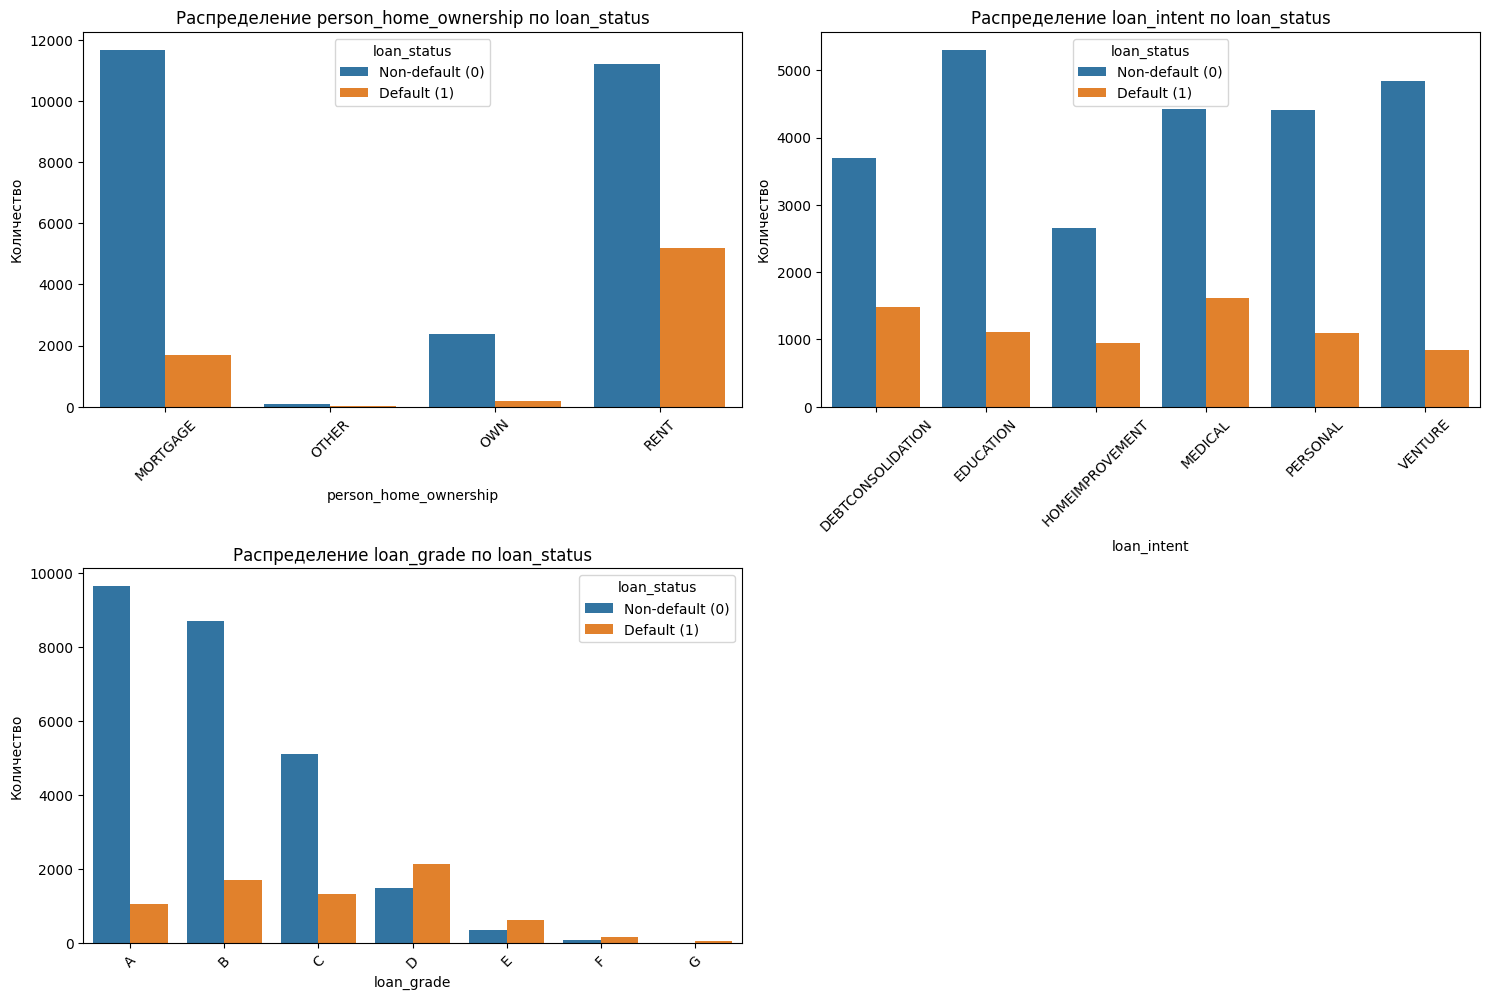

In [ ]:
plt.figure(figsize=(15, len(categorical_cols) * 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 2, i)
    sns.countplot(data=df, x=col, hue=target)
    plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {col} –ø–æ {target}')
    plt.xlabel(col)
    plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ')
    plt.xticks(rotation=45)
    plt.legend(title=target, labels=['Non-default (0)', 'Default (1)'])

plt.tight_layout()
plt.show()

# –õ–æ–≥–∏—á–µ—Å–∫–∞—è –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞

## –ß–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏

### –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤

In [ ]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [ ]:
df['person_emp_length'].head()

0    123.0
1      5.0
2      1.0
3      4.0
4      8.0
Name: person_emp_length, dtype: float64

In [ ]:
df['person_emp_length'] = df['person_emp_length'].fillna(0)

In [ ]:
df['loan_int_rate'].head()

0    16.02
1    11.14
2    12.87
3    15.23
4    14.27
Name: loan_int_rate, dtype: float64

loan_int_rate –ø—Ä–∏–∑–Ω–∞–∫ –æ–±—Ä–∞–±–æ—Ç–∞—é —Ç–æ–ª—å–∫–æ –ø–æ—Å–ª–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –¥–∞–Ω–Ω—ã—Ö. –°—Ä–µ–¥–Ω–∏–º–∏ –¥–∞–Ω–Ω—ã–º–∏, –ø–æ—Ç–æ–º—É —á—Ç–æ –µ—Å–ª–∏ —Å–µ–π—á–∞—Å –∑–∞–ø–æ–ª–Ω–∏—Ç—å, —Ç–æ –±—É–¥–µ—Ç —É—Ç–µ—á–∫–∞ –¥–∞–Ω–Ω—ã—Ö

### –û–±—Ä–∞–±–æ—Ç–∫–∞ –≤—ã–±—Ä–æ—Å–æ–≤

In [ ]:
data_one = df.copy()

In [ ]:
def clean_numeric_data(df):
    # –°–ø–∏—Å–æ–∫ —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # –ü—Ä–∞–≤–∏–ª–∞ –æ—á–∏—Å—Ç–∫–∏
    rules = {
        'person_age': {'min': 0, 'max': 120}, # –í–æ–∑—Ä–∞—Å—Ç –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–º –∏ –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å —Å–ª–∏—à–∫–æ–º –±–æ–ª—å—à–∏–º (–Ω–∞–ø—Ä–∏–º–µ—Ä, > 120 –ª–µ—Ç)
        'person_income': {'min': 0, 'max': 1e20}, # –î–æ—Ö–æ–¥ –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–º –∏ –î–æ—Ö–æ–¥ –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å —á—Ä–µ–∑–º–µ—Ä–Ω–æ –≤—ã—Å–æ–∫–∏–º (–Ω–∞–ø—Ä–∏–º–µ—Ä, > $1M ‚Äî —Ä–µ–¥–∫–æ, –Ω–æ –≤–æ–∑–º–æ–∂–Ω–æ)
        'person_emp_length': {'min': 0, 'max': 100}, # –°—Ç–∞–∂ –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–º –∏ –°—Ç–∞–∂ –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –±–æ–ª—å—à–µ –≤–æ–∑—Ä–∞—Å—Ç–∞
        'loan_amnt': {'min': 0, 'max': 1e10}, # –ö—Ä–µ–¥–∏—Ç –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–º –∏ –ö—Ä–µ–¥–∏—Ç –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å —Å–ª–∏—à–∫–æ–º –±–æ–ª—å—à–∏–º (–Ω–∞–ø—Ä–∏–º–µ—Ä, > $1M)
        'loan_int_rate': {'min': 0, 'max': 100}, # –°—Ç–∞–≤–∫–∞ –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω–æ–π –∏ –°—Ç–∞–≤–∫–∞ –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å —á—Ä–µ–∑–º–µ—Ä–Ω–æ –≤—ã—Å–æ–∫–æ–π (–Ω–∞–ø—Ä–∏–º–µ—Ä, > 100%)
        'loan_percent_income': {'min': 0, 'max': 200}, # –ù–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω–æ–π –∏ –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–æ —Ä–∞–∑—É–º–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ ‚Äî –Ω–∞–ø—Ä–∏–º–µ—Ä, 200% (—Ö–æ—Ç—è –∏ —Ä–µ–¥–∫–æ)
        'cb_person_cred_hist_length': {'min': 0, 'max': 100} # –ù–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω–æ–π –∏ –ù–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –±–æ–ª—å—à–µ –≤–æ–∑—Ä–∞—Å—Ç–∞
    }

    for col in numeric_cols:
        if col in rules:
            min_val, max_val = rules[col]['min'], rules[col]['max']

            # –†–∞–±–æ—Ç–∞–µ–º —Ç–æ–ª—å–∫–æ —Å –Ω–µ–ø—É—Å—Ç—ã–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏
            mask = df[col].notna()
            # –ó–∞–º–µ–Ω—è–µ–º –≤—ã–±—Ä–æ—Å—ã –Ω–∞ NaN (–∏–ª–∏ —É–¥–∞–ª—è–µ–º ‚Äî –Ω–æ –Ω–µ —Å–µ–π—á–∞—Å)
            df.loc[mask, col] = df.loc[mask, col].where(
                (df.loc[mask, col] >= min_val) & (df.loc[mask, col] <= max_val)
            )

    return df

In [ ]:
df = clean_numeric_data(df)

In [ ]:
print(f"–û—Å—Ç–∞–ª–æ—Å—å —Å—Ç—Ä–æ–∫: {len(df)}")
print(f"–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: {len(data_one) - len(df)}")
print((len(data_one) - len(df)) / len(df) * 100)

–û—Å—Ç–∞–ª–æ—Å—å —Å—Ç—Ä–æ–∫: 32416
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 0
0.0


In [ ]:
# –ü—Ä–æ–≤–µ—Ä–∫–∞: —Å—Ç–∞–∂ –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –±–æ–ª—å—à–µ –≤–æ–∑—Ä–∞—Å—Ç–∞
df = df[df['person_emp_length'] <= df['person_age']]

# –ü—Ä–æ–≤–µ—Ä–∫–∞: –∫—Ä–µ–¥–∏—Ç–Ω–∞—è –∏—Å—Ç–æ—Ä–∏—è –Ω–µ –º–æ–∂–µ—Ç –±—ã—Ç—å –±–æ–ª—å—à–µ –≤–æ–∑—Ä–∞—Å—Ç–∞
df = df[df['cb_person_cred_hist_length'] <= df['person_age']]

In [ ]:
df.shape

(32409, 12)

### –ü—Ä–æ—Å–º–æ—Ä—Ç –≤—ã–±—Ä–æ—Å–æ–≤ —Å–Ω–æ–≤–∞ –∏ –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–∏–µ

–ê–Ω–∞–ª–∏–∑–∏—Ä—É—é 8 —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']


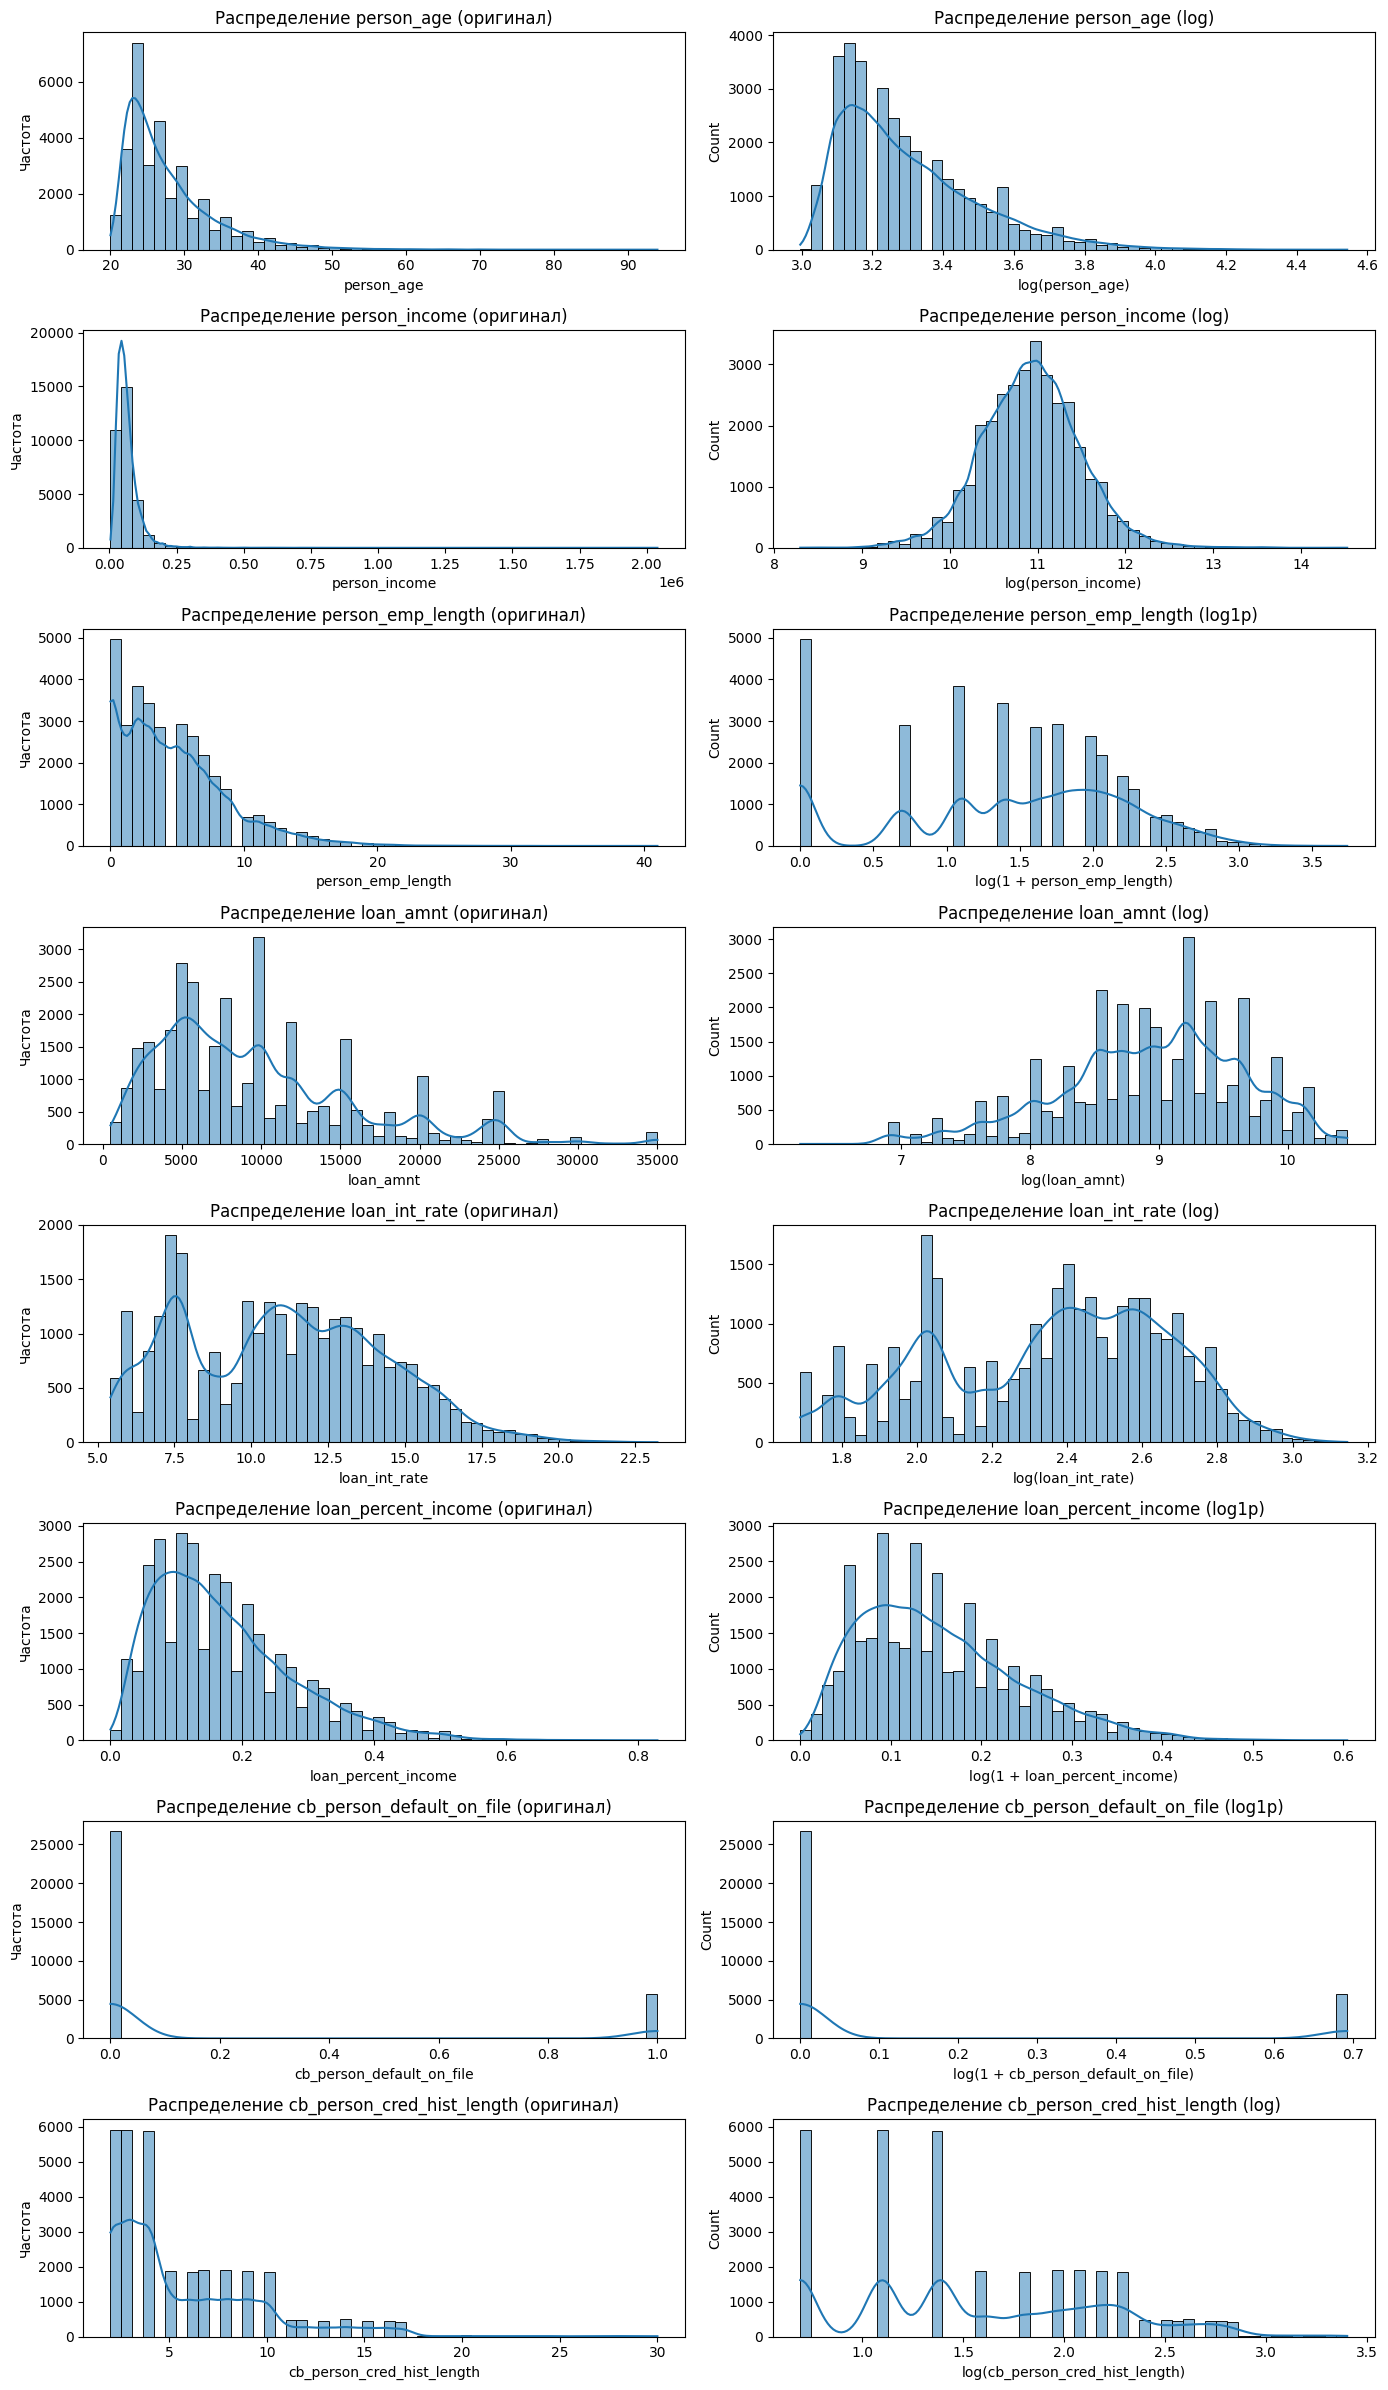

In [ ]:
def plot_numeric_with_log(df, target=target):
    """
    –î–ª—è –∫–∞–∂–¥–æ–≥–æ —á–∏—Å–ª–æ–≤–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ —Å—Ç—Ä–æ–∏—Ç –¥–≤–∞ –≥—Ä–∞—Ñ–∏–∫–∞:
    - —Å–ª–µ–≤–∞: –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
    - —Å–ø—Ä–∞–≤–∞: –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ

    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    df - –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
    target - –∏–º—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π (—á—Ç–æ–±—ã –∏—Å–∫–ª—é—á–∏—Ç—å –µ—ë –∏–∑ –∞–Ω–∞–ª–∏–∑–∞)
    """
    # –í—ã–±–∏—Ä–∞–µ–º —Ç–æ–ª—å–∫–æ —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # –ò—Å–∫–ª—é—á–∞–µ–º —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é, –µ—Å–ª–∏ –æ–Ω–∞ —á–∏—Å–ª–æ–≤–∞
    if target in numeric_cols:
        numeric_cols.remove(target)

    # –ï—Å–ª–∏ –Ω–µ—Ç —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    if not numeric_cols:
        print("–ù–µ—Ç —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞")
        return

    print(f"–ê–Ω–∞–ª–∏–∑–∏—Ä—É—é {len(numeric_cols)} —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {numeric_cols}")

    # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –≤ —Å–µ—Ç–∫–µ
    n_rows = len(numeric_cols)
    fig_height = max(4, n_rows * 3)  # –º–∏–Ω–∏–º—É–º 4 –¥—é–π–º–∞, –∏–Ω–∞—á–µ –≥—Ä–∞—Ñ–∏–∫–∏ –±—É–¥—É—Ç —Å–ª–∏—à–∫–æ–º –º–∞–ª—ã

    # –°–æ–∑–¥–∞–µ–º —Ñ–∏–≥—É—Ä—É: n_rows —Å—Ç—Ä–æ–∫, 2 —Å—Ç–æ–ª–±—Ü–∞ (–æ—Ä–∏–≥–∏–Ω–∞–ª + –ª–æ–≥)
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, fig_height))

    # –ï—Å–ª–∏ —Ç–æ–ª—å–∫–æ –æ–¥–∏–Ω –ø—Ä–∏–∑–Ω–∞–∫, axes –Ω–µ –±—É–¥–µ—Ç 2D –º–∞—Å—Å–∏–≤–æ–º
    if n_rows == 1:
        axes = np.array([axes])  # –¥–µ–ª–∞–µ–º –∏–∑ 1D –º–∞—Å—Å–∏–≤–∞ 2D

    # –î–ª—è –∫–∞–∂–¥–æ–≥–æ —á–∏—Å–ª–æ–≤–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞
    for i, col in enumerate(numeric_cols):
        # –û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
        ax_orig = axes[i, 0] if n_rows > 1 else axes[0]
        data = df[col].dropna()

        if len(data) > 0:
            sns.histplot(data, bins=50, kde=True, ax=ax_orig)
            ax_orig.set_title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {col} (–æ—Ä–∏–≥–∏–Ω–∞–ª)')
            ax_orig.set_xlabel(col)
            ax_orig.set_ylabel('–ß–∞—Å—Ç–æ—Ç–∞')
        else:
            ax_orig.text(0.5, 0.5, '–ù–µ—Ç –¥–∞–Ω–Ω—ã—Ö', ha='center', va='center',
                         transform=ax_orig.transAxes)

        # –õ–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
        ax_log = axes[i, 1] if n_rows > 1 else axes[1]

        # –ü—Ä–æ–≤–µ—Ä—è–µ–º, –µ—Å—Ç—å –ª–∏ –Ω—É–ª–∏/–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è (–¥–ª—è log1p)
        has_non_positive = (data <= 0).any()

        if len(data) > 0 and not has_non_positive:
            log_data = np.log(data)
            sns.histplot(log_data, bins=50, kde=True, ax=ax_log)
            ax_log.set_title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {col} (log)')
            ax_log.set_xlabel(f'log({col})')
        elif len(data) > 0:
            # –ò—Å–ø–æ–ª—å–∑—É–µ–º log1p –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ –Ω—É–ª–µ–π
            log_data = np.log1p(data)
            sns.histplot(log_data, bins=50, kde=True, ax=ax_log)
            ax_log.set_title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {col} (log1p)')
            ax_log.set_xlabel(f'log(1 + {col})')
        else:
            ax_log.text(0.5, 0.5, '–ù–µ—Ç –¥–∞–Ω–Ω—ã—Ö', ha='center', va='center',
                        transform=ax_log.transAxes)

    plt.tight_layout()
    plt.show()

# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è:
plot_numeric_with_log(df, target=target)

In [ ]:
df['person_income'] = np.log(df['person_income'])

<Axes: xlabel='person_income', ylabel='Count'>

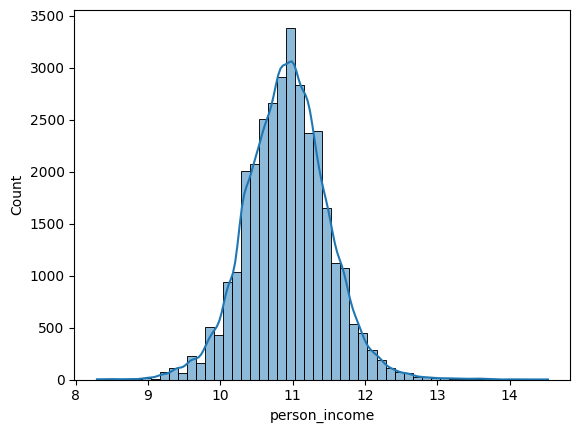

In [ ]:
sns.histplot(df['person_income'], bins=50, kde=True)

### **–í—ã–≤–æ–¥**
1. –ü—Ä–æ–ø—É—Å–∫–∏: person_emp_length –∏–º–µ–µ—Ç –≤—ã–±—Ä–æ—Å—ã –∏ –∏—Ö –æ–±—Ä–∞–±–æ—Ç–∞—é —Å –ø–æ–º–æ—â—å—é –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è –º–µ–¥–∏–∞–Ω–æ–π –≤ –≥—Ä—É–ø–ø–µ
2. –í—ã–±—Ä–æ—Å—ã: person_income –æ–±—Ä–∞–±–æ—Ç–∞–ª —Å –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–∏–µ–º, –æ—Å—Ç–∞–ª—å–Ω—ã–µ —Å –Ω–µ–ø–∞—Ä–∞–º–µ—Ç—Ä–∏—á–µ—Å–∫–∏–º–∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è. –ù–æ —Ç–æ–ª—å–∫–æ —Ç–µ –¥–∞–Ω–Ω—ã–µ, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–∂–Ω–æ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞—Ç—å

In [ ]:
# plt.figure(figsize=(14, 10))
# for i, col in enumerate(numeric_cols, 1):
#     plt.subplot(3, 3, i)
#     sns.histplot(df[col].dropna(), bins=50, kde=True)
#     plt.title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {col}')
#     plt.xlabel(col)
# plt.tight_layout()
# plt.show()

## –ö–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏


üîç –ü—Ä–∏–∑–Ω–∞–∫: person_home_ownership
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è: ['OWN', 'MORTGAGE', 'RENT', 'OTHER']
Categories (4, object): ['MORTGAGE', 'OTHER', 'OWN', 'RENT']
–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π:
person_home_ownership
RENT        50.523003
MORTGAGE    41.241630
OWN          7.908297
OTHER        0.327070
Name: proportion, dtype: float64

–û–ø–∏—Å–∞–Ω–∏–µ:
count     32409
unique        4
top        RENT
freq      16374
Name: person_home_ownership, dtype: object


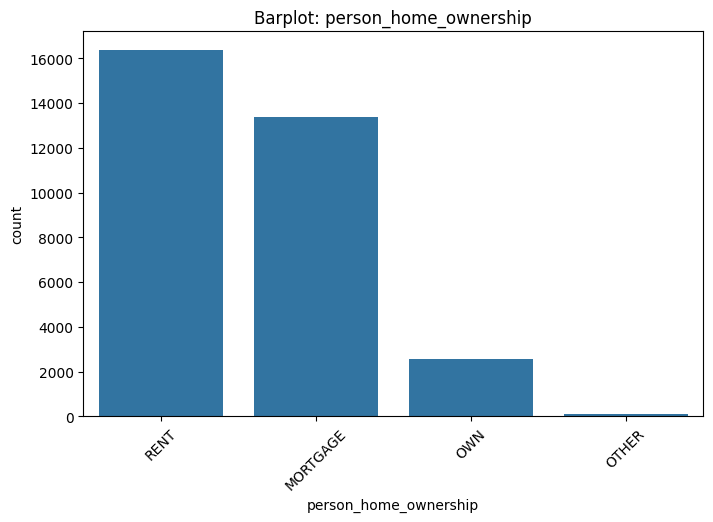


üîç –ü—Ä–∏–∑–Ω–∞–∫: loan_intent
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è: ['EDUCATION', 'MEDICAL', 'VENTURE', 'PERSONAL', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION']
Categories (6, object): ['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL',
                         'VENTURE']
–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π:
loan_intent
EDUCATION            19.775371
MEDICAL              18.642970
VENTURE              17.522910
PERSONAL             16.958252
DEBTCONSOLIDATION    16.010985
HOMEIMPROVEMENT      11.089512
Name: proportion, dtype: float64

–û–ø–∏—Å–∞–Ω–∏–µ:
count         32409
unique            6
top       EDUCATION
freq           6409
Name: loan_intent, dtype: object


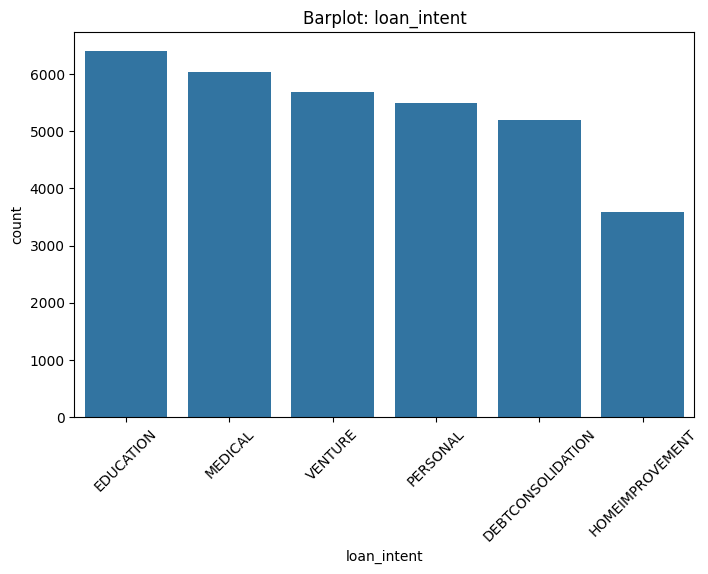


üîç –ü—Ä–∏–∑–Ω–∞–∫: loan_grade
–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è: ['B', 'C', 'A', 'D', 'E', 'F', 'G']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']
–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π:
loan_grade
A    33.021692
B    32.040483
C    19.858681
D    11.166651
E     2.971397
F     0.743621
G     0.197476
Name: proportion, dtype: float64

–û–ø–∏—Å–∞–Ω–∏–µ:
count     32409
unique        7
top           A
freq      10702
Name: loan_grade, dtype: object


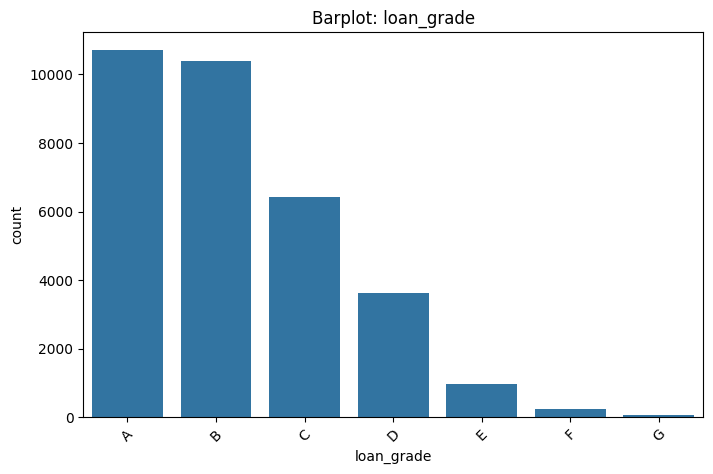

In [ ]:
for col in categorical_cols:
    print(f"\nüîç –ü—Ä–∏–∑–Ω–∞–∫: {col}")

    # .unique() –∏ .value_counts()
    unique_values = df[col].unique()
    value_counts = df[col].value_counts(normalize=True) * 100

    print(f"–£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è: {unique_values}")
    print(f"–ß–∞—Å—Ç–æ—Ç–∞ –∑–Ω–∞—á–µ–Ω–∏–π:\n{value_counts}")

    # df.describe()
    print(f"\n–û–ø–∏—Å–∞–Ω–∏–µ:")
    print(df[col].describe())

    # Barplot
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, order=value_counts.index)
    plt.title(f'Barplot: {col}')
    plt.xticks(rotation=45)
    plt.show()

### –ò—Å–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –≤—ã–±—Ä–æ—Å–æ–≤

In [ ]:
df['loan_grade'] = df['loan_grade'].replace(['F', 'G'], 'Other')

<Axes: xlabel='loan_grade', ylabel='count'>

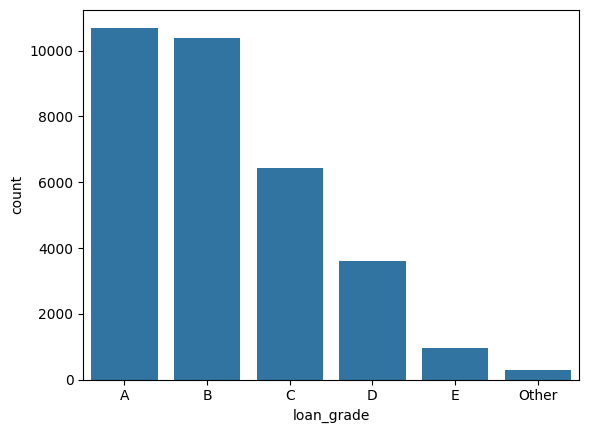

In [ ]:
sns.countplot(data=df, x='loan_grade')

In [ ]:
# –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ loan_grade ‚Äî –∫–∞—Ç–µ–≥–æ—Ä–∏—è —Å –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º –ø–æ—Ä—è–¥–∫–æ–º
grade_order = ['A', 'B', 'C', 'D', 'E', 'Other']
df['loan_grade'] = pd.Categorical(df['loan_grade'], categories=grade_order, ordered=True)

### **–í—ã–≤–æ–¥**
–í —Å—Ç–æ–ª–±—Ü–µ loan_grade G –∏ H –∑–∞–º–µ–Ω–∏–ª –Ω–∞ other, –ø–æ—Ç–æ–º—É —á—Ç–æ –∏—Ö –º–µ–Ω—å—à–µ 1%. –ü—Ä–æ–ø—É—Å–∫–æ–≤ –Ω–µ—Ç

LabelEncoder: loan_grade. –û—Å—Ç–∞–ª—å–Ω—ã–µ OneHotEncoder

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö

In [ ]:
# –í—ã–¥–µ–ª—è–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –∏ —Ç–∞—Ä–≥–µ—Ç
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# –†–∞–∑–¥–µ–ª—è–µ–º
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [ ]:
# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ä–∞–∑–º–µ—Ä–æ–≤
print(f"Train: {len(X_train)} ({len(X_train)/len(df):.2%})")
print(f"Val:   {len(X_val)} ({len(X_val)/len(df):.2%})")
print(f"Test:  {len(X_test)} ({len(X_test)/len(df):.2%})")

Train: 22686 (70.00%)
Val:   4861 (15.00%)
Test:  4862 (15.00%)


# –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞

## –ß–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏

In [ ]:
X_train.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2197
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

### –û–±—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–æ–ø—É—Å–∫–æ–≤

In [ ]:
def fill_missing_grouped(df, group_col, target_cols):
    for col in target_cols:
        df[col] = df.groupby(group_col)[col].transform(
            lambda x: x.fillna(x.median())
        )
    return df

In [ ]:
X_train = fill_missing_grouped(X_train, 'loan_grade', ['loan_int_rate'])
X_val = fill_missing_grouped(X_val, 'loan_grade', ['loan_int_rate'])
X_test = fill_missing_grouped(X_test, 'loan_grade', ['loan_int_rate'])

In [ ]:
X_train.isnull().sum(), X_val.isnull().sum(), X_test.isnull().sum()

(person_age                    0
 person_income                 0
 person_home_ownership         0
 person_emp_length             0
 loan_intent                   0
 loan_grade                    0
 loan_amnt                     0
 loan_int_rate                 0
 loan_percent_income           0
 cb_person_default_on_file     0
 cb_person_cred_hist_length    0
 dtype: int64,
 person_age                    0
 person_income                 0
 person_home_ownership         0
 person_emp_length             0
 loan_intent                   0
 loan_grade                    0
 loan_amnt                     0
 loan_int_rate                 0
 loan_percent_income           0
 cb_person_default_on_file     0
 cb_person_cred_hist_length    0
 dtype: int64,
 person_age                    0
 person_income                 0
 person_home_ownership         0
 person_emp_length             0
 loan_intent                   0
 loan_grade                    0
 loan_amnt                     0
 loan_int_rat

### –û–±—Ä–∞–±–æ—Ç–∫–∞ –≤—ã–±—Ä–æ—Å–æ–≤

In [ ]:
def plot_numeric_with_log(df, target=target):
    """
    –î–ª—è –∫–∞–∂–¥–æ–≥–æ —á–∏—Å–ª–æ–≤–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞ —Å—Ç—Ä–æ–∏—Ç –¥–≤–∞ –≥—Ä–∞—Ñ–∏–∫–∞:
    - —Å–ª–µ–≤–∞: –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
    - —Å–ø—Ä–∞–≤–∞: –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ

    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    df - –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
    target - –∏–º—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π (—á—Ç–æ–±—ã –∏—Å–∫–ª—é—á–∏—Ç—å –µ—ë –∏–∑ –∞–Ω–∞–ª–∏–∑–∞)
    """
    # –í—ã–±–∏—Ä–∞–µ–º —Ç–æ–ª—å–∫–æ —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # –ò—Å–∫–ª—é—á–∞–µ–º —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é, –µ—Å–ª–∏ –æ–Ω–∞ —á–∏—Å–ª–æ–≤–∞
    if target in numeric_cols:
        numeric_cols.remove(target)

    # –ï—Å–ª–∏ –Ω–µ—Ç —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    if not numeric_cols:
        print("–ù–µ—Ç —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞")
        return

    print(f"–ê–Ω–∞–ª–∏–∑–∏—Ä—É—é {len(numeric_cols)} —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {numeric_cols}")

    # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –≤ —Å–µ—Ç–∫–µ
    n_rows = len(numeric_cols)
    fig_height = max(4, n_rows * 3)  # –º–∏–Ω–∏–º—É–º 4 –¥—é–π–º–∞, –∏–Ω–∞—á–µ –≥—Ä–∞—Ñ–∏–∫–∏ –±—É–¥—É—Ç —Å–ª–∏—à–∫–æ–º –º–∞–ª—ã

    # –°–æ–∑–¥–∞–µ–º —Ñ–∏–≥—É—Ä—É: n_rows —Å—Ç—Ä–æ–∫, 2 —Å—Ç–æ–ª–±—Ü–∞ (–æ—Ä–∏–≥–∏–Ω–∞–ª + –ª–æ–≥)
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, fig_height))

    # –ï—Å–ª–∏ —Ç–æ–ª—å–∫–æ –æ–¥–∏–Ω –ø—Ä–∏–∑–Ω–∞–∫, axes –Ω–µ –±—É–¥–µ—Ç 2D –º–∞—Å—Å–∏–≤–æ–º
    if n_rows == 1:
        axes = np.array([axes])  # –¥–µ–ª–∞–µ–º –∏–∑ 1D –º–∞—Å—Å–∏–≤–∞ 2D

    # –î–ª—è –∫–∞–∂–¥–æ–≥–æ —á–∏—Å–ª–æ–≤–æ–≥–æ –ø—Ä–∏–∑–Ω–∞–∫–∞
    for i, col in enumerate(numeric_cols):
        # –û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
        ax_orig = axes[i, 0] if n_rows > 1 else axes[0]
        data = df[col].dropna()

        if len(data) > 0:
            sns.histplot(data, bins=50, kde=True, ax=ax_orig)
            ax_orig.set_title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {col} (–æ—Ä–∏–≥–∏–Ω–∞–ª)')
            ax_orig.set_xlabel(col)
            ax_orig.set_ylabel('–ß–∞—Å—Ç–æ—Ç–∞')
        else:
            ax_orig.text(0.5, 0.5, '–ù–µ—Ç –¥–∞–Ω–Ω—ã—Ö', ha='center', va='center',
                         transform=ax_orig.transAxes)

        # –õ–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ
        ax_log = axes[i, 1] if n_rows > 1 else axes[1]

        # –ü—Ä–æ–≤–µ—Ä—è–µ–º, –µ—Å—Ç—å –ª–∏ –Ω—É–ª–∏/–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è (–¥–ª—è log1p)
        has_non_positive = (data <= 0).any()

        if len(data) > 0 and not has_non_positive:
            log_data = np.log(data)
            sns.histplot(log_data, bins=50, kde=True, ax=ax_log)
            ax_log.set_title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {col} (log)')
            ax_log.set_xlabel(f'log({col})')
        elif len(data) > 0:
            # –ò—Å–ø–æ–ª—å–∑—É–µ–º log1p –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ –Ω—É–ª–µ–π
            log_data = np.log1p(data)
            sns.histplot(log_data, bins=50, kde=True, ax=ax_log)
            ax_log.set_title(f'–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ {col} (log1p)')
            ax_log.set_xlabel(f'log(1 + {col})')
        else:
            ax_log.text(0.5, 0.5, '–ù–µ—Ç –¥–∞–Ω–Ω—ã—Ö', ha='center', va='center',
                        transform=ax_log.transAxes)

    plt.tight_layout()
    plt.show()

–ê–Ω–∞–ª–∏–∑–∏—Ä—É—é 8 —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']


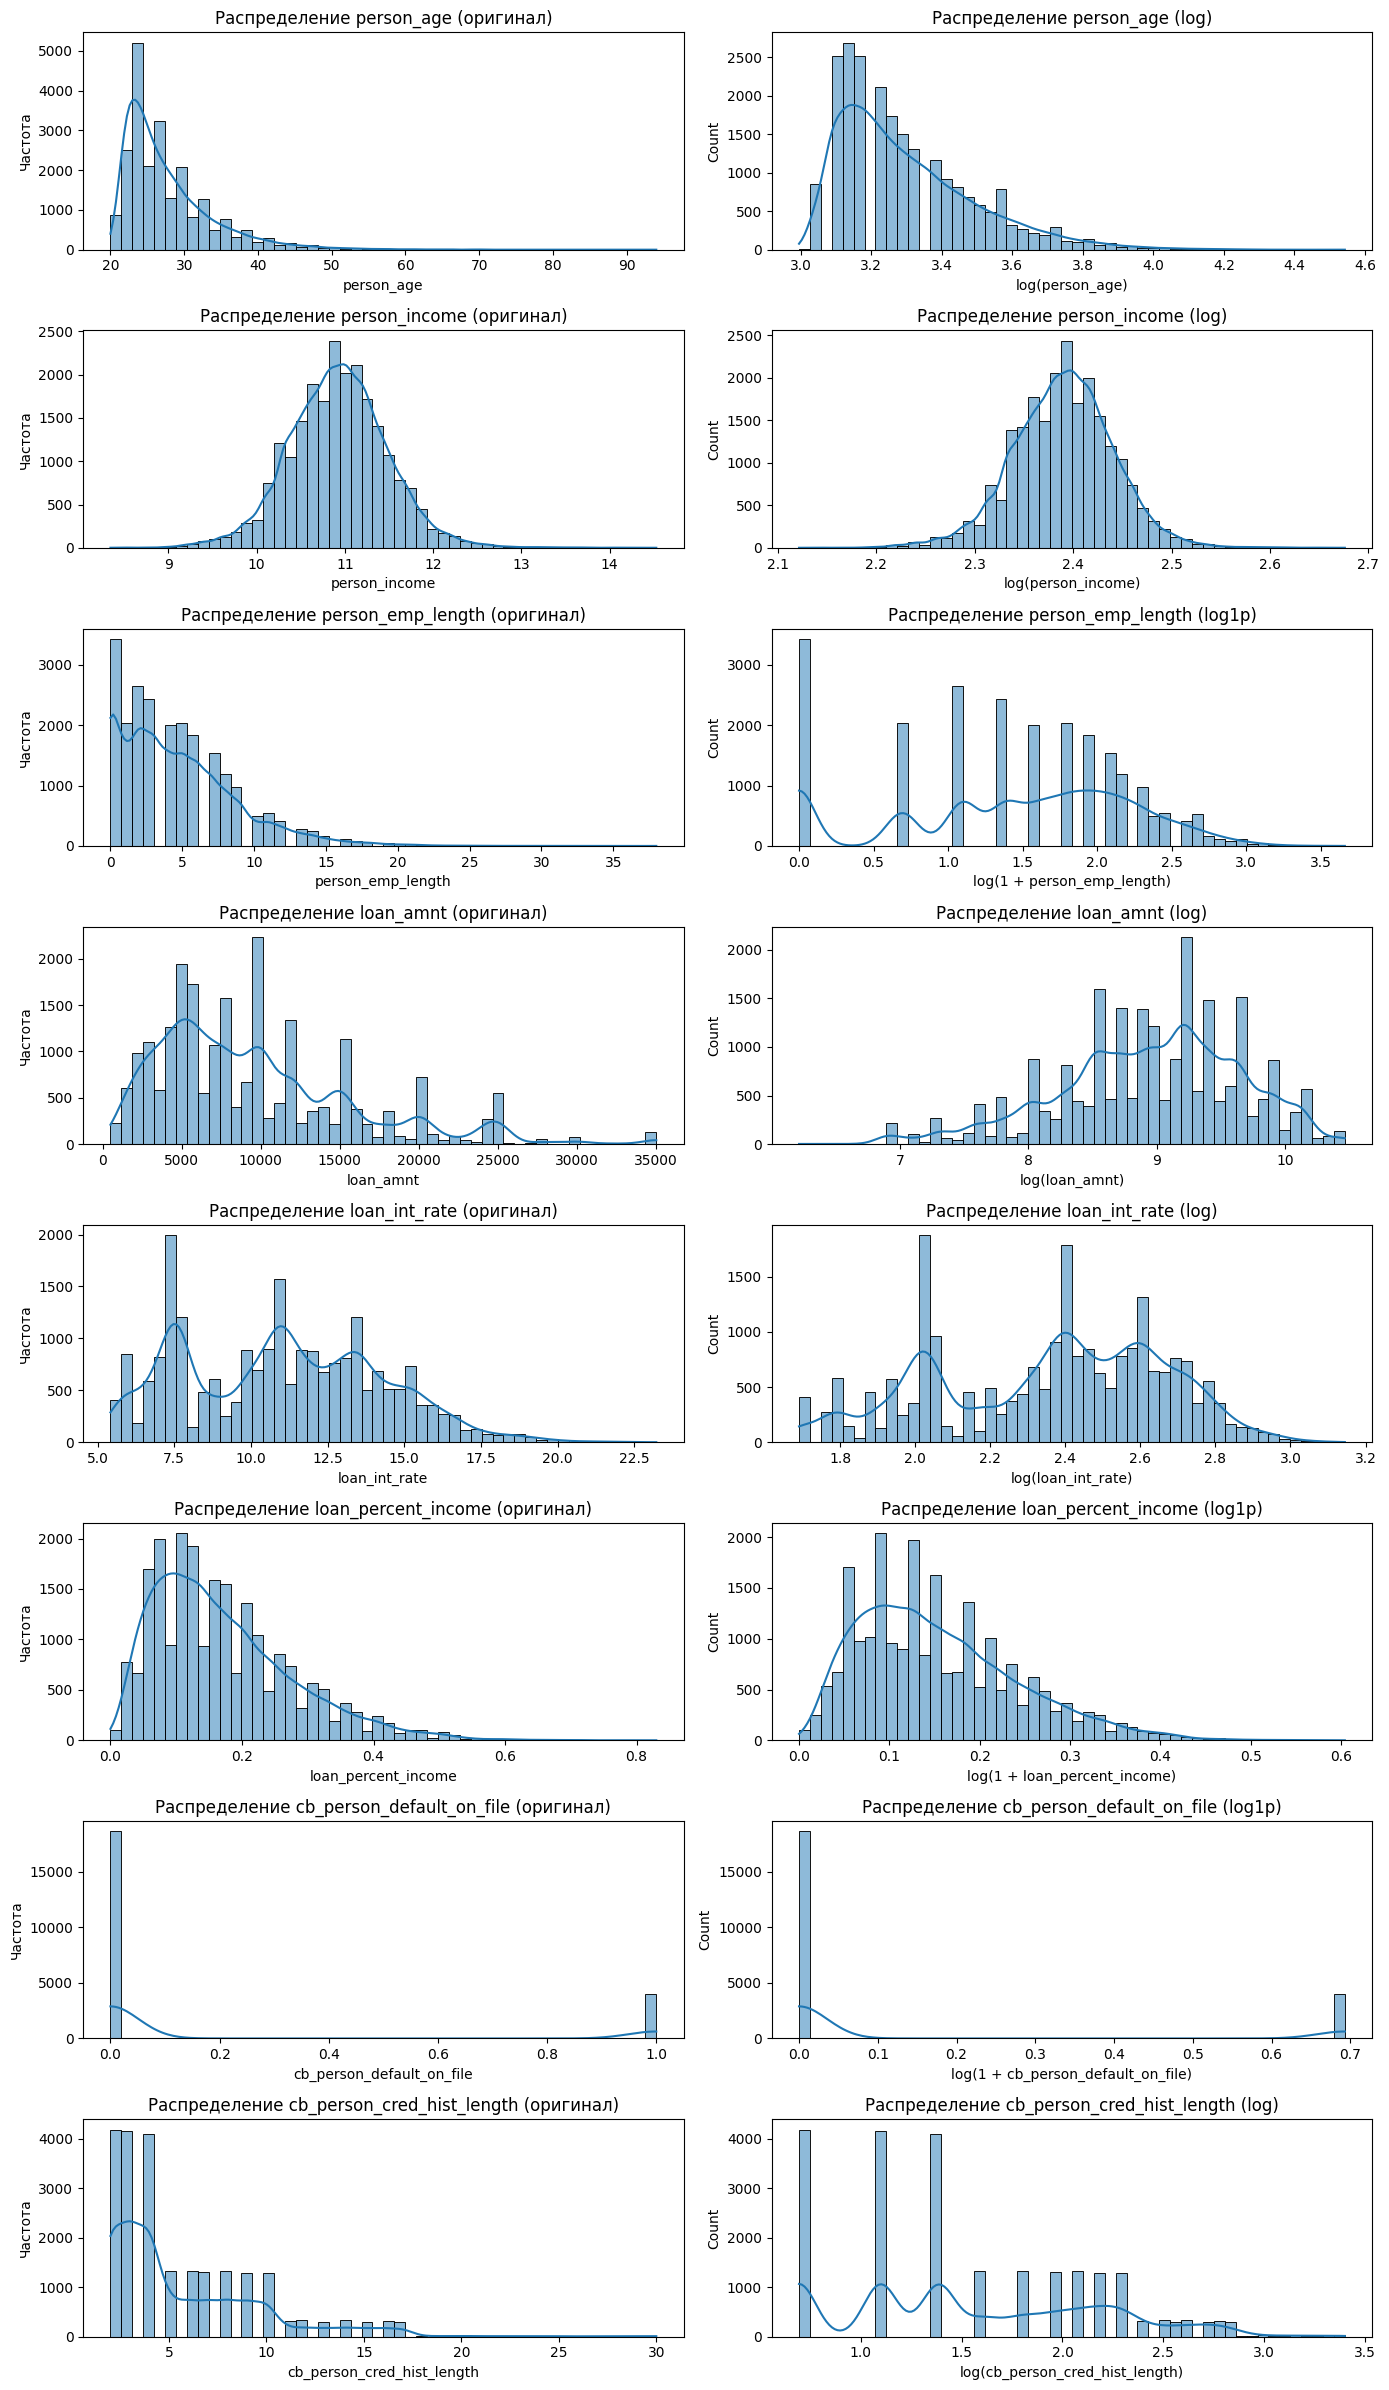

In [ ]:
# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è:
plot_numeric_with_log(X_train, target=target)

In [ ]:
# –í—ã–±–∏—Ä–∞–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è
features = [
    'person_age',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length'
]

In [ ]:
X_train_transformed = X_train.copy()
X_val_transformed = X_val.copy()
X_test_transformed = X_test.copy()

# –°–ª–æ–≤–∞—Ä—å –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ lambda
lambdas = {}

for col in features:
    # –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ –≤—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è > 0
    if (X_train[col] <= 0).any():
        # –î–æ–±–∞–≤–ª—è–µ–º –∫–æ–Ω—Å—Ç–∞–Ω—Ç—É
        shift = abs(X_train[col].min()) + 1
        X_train_shifted = X_train[col] + shift
        X_val_shifted = X_val[col] + shift
        X_test_shifted = X_test[col] + shift
    else:
        X_train_shifted = X_train[col]
        X_val_shifted = X_val[col]
        X_test_shifted = X_test[col]

    # –ü—Ä–∏–º–µ–Ω—è–µ–º Box-Cox
    try:
        data, lambda_ = stats.boxcox(X_train_shifted)
        lambdas[col] = (lambda_, shift if 'shift' in locals() else 0)

        # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º train
        X_train_transformed[col] = data

        # –ü—Ä–∏–º–µ–Ω—è–µ–º –∫ val –∏ test —Å —Ç–µ–º–∏ –∂–µ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
        if 'shift' in locals():
            X_val_transformed[col] = stats.boxcox(X_val_shifted, lmbda=lambda_)
            X_test_transformed[col] = stats.boxcox(X_test_shifted, lmbda=lambda_)
        else:
            X_val_transformed[col] = stats.boxcox(X_val[col], lmbda=lambda_)
            X_test_transformed[col] = stats.boxcox(X_test[col], lmbda=lambda_)
    except Exception as e:
        print(f"–ù–µ —É–¥–∞–ª–æ—Å—å –ø—Ä–∏–º–µ–Ω–∏—Ç—å Box-Cox –∫ {col}: {e}")

In [ ]:
joblib.dump(lambdas, 'lambdas.pkl')

['lambdas.pkl']

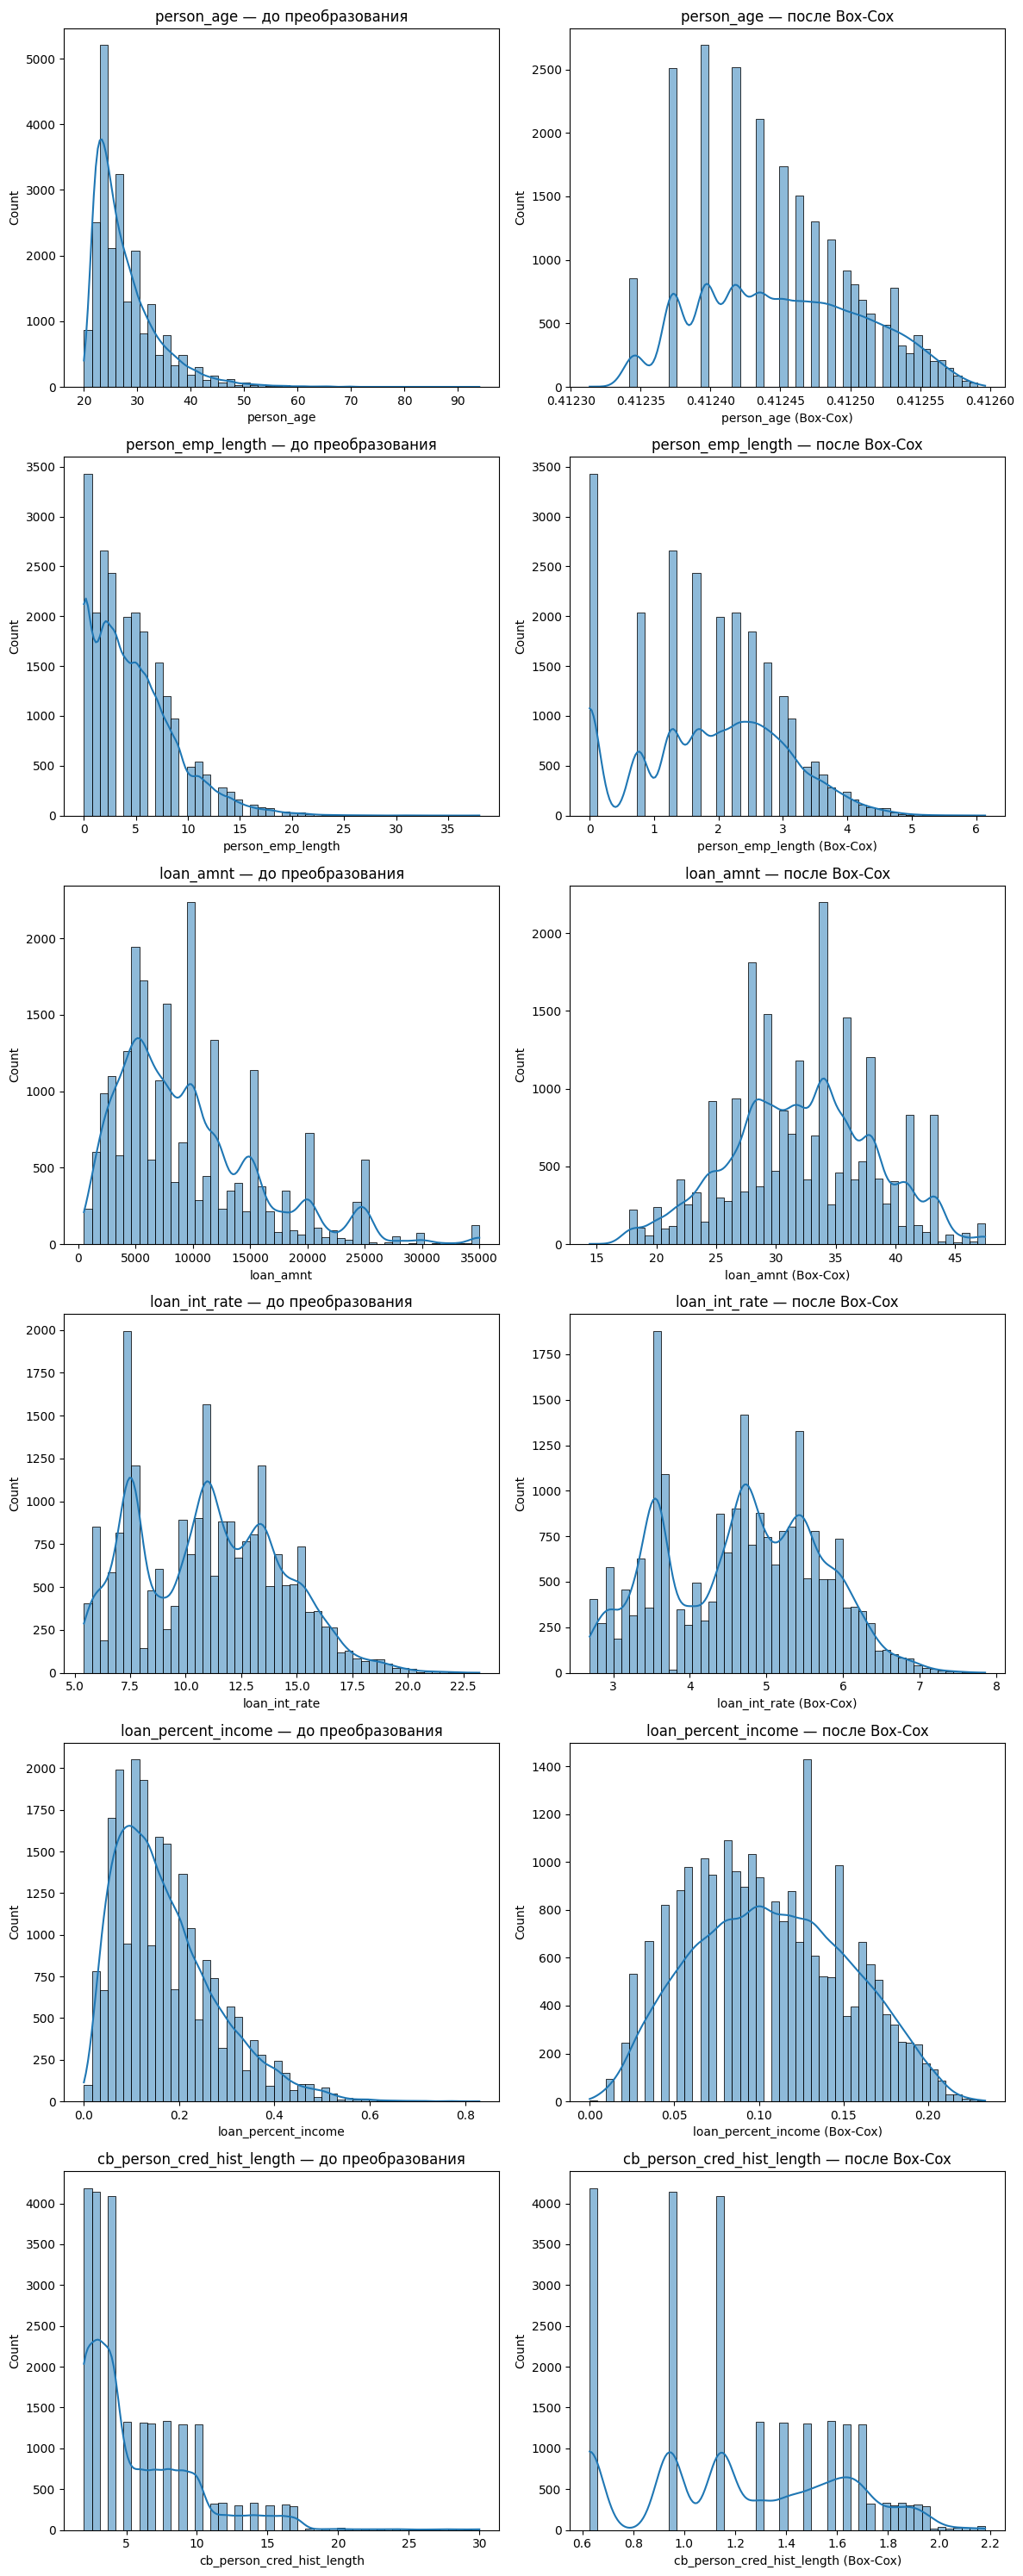

In [ ]:
fig, axes = plt.subplots(len(features), 2, figsize=(12, 5 * len(features)))

for i, col in enumerate(features):
    # –î–æ
    sns.histplot(X_train[col], bins=50, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} ‚Äî –¥–æ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è')
    axes[i, 0].set_xlabel(col)

    # –ü–æ—Å–ª–µ
    sns.histplot(X_train_transformed[col], bins=50, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} ‚Äî –ø–æ—Å–ª–µ Box-Cox')
    axes[i, 1].set_xlabel(f'{col} (Box-Cox)')

plt.tight_layout()
plt.show()

## –í—ã–≤–æ–¥
–ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ —Å–¥–µ–ª–∞–Ω–∞.
–î–ª—è Pipeline:
1. –û—Å—Ç–∞–ª–æ—Å—å –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å–¥–µ–ª–∞—Ç—å –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏–µ
2. –î–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω—É–∂–Ω–æ —Å–¥–µ–ª–∞—Ç—å –∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏–µ

# –ü—Ä–æ–≤–µ—Ä–∫–∞ —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏—Ö –≥–∏–ø–æ—Ç–µ–∑

## –ú–µ—Ç–æ–¥ –ø—Ä–æ–≤–µ—Ä–∫–∏: Z-—Ç–µ—Å—Ç –¥–ª—è –¥–æ–ª–µ–π (proportions z-test)

–ì–∏–ø–æ—Ç–µ–∑–∞ 1: –õ—é–¥–∏ —Å –∏—Å—Ç–æ—Ä–∏–µ–π –ø—Ä–æ—Å—Ä–æ—á–µ–∫ (cb_person_default_on_file = Y) –∏–º–µ—é—Ç –∑–Ω–∞—á–∏–º–æ –±–æ–ª–µ–µ –≤—ã—Å–æ–∫—É—é –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –¥–µ—Ñ–æ–ª—Ç–∞, —á–µ–º —Ç–µ, —É –∫–æ–≥–æ –µ—ë –Ω–µ—Ç.


üîç –§–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è:

H‚ÇÄ (–Ω—É–ª–µ–≤–∞—è –≥–∏–ø–æ—Ç–µ–∑–∞): –î–æ–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤ –æ–¥–∏–Ω–∞–∫–æ–≤–∞ —É –ª—é–¥–µ–π —Å Y –∏ N.

H‚ÇÅ (–∞–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–∞—è): –î–æ–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤ –≤—ã—à–µ —É –ª—é–¥–µ–π —Å Y.

In [ ]:
# –î–∞–Ω–Ω—ã–µ
has_default = df[df['cb_person_default_on_file'] == 1]
no_default = df[df['cb_person_default_on_file'] == 0]

# –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–µ—Ñ–æ–ª—Ç–æ–≤ –∏ –æ–±—â–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ
successes = [has_default['loan_status'].sum(), no_default['loan_status'].sum()]
nobs = [len(has_default), len(no_default)]

# Z-—Ç–µ—Å—Ç
z_stat, p_value = proportions_ztest(count=successes, nobs=nobs, alternative='larger')

print(f"Z-—Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: {z_stat:.3f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("‚úÖ –û—Ç–∫–ª–æ–Ω—è–µ–º H‚ÇÄ: –õ—é–¥–∏ —Å –∏—Å—Ç–æ—Ä–∏–µ–π –¥–µ—Ñ–æ–ª—Ç–∞ –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ —á–∞—â–µ –¥–µ—Ñ–æ–ª—Ç—è—Ç.")
else:
    print("‚ùå –ù–µ –æ—Ç–∫–ª–æ–Ω—è–µ–º H‚ÇÄ: –ù–µ—Ç –∑–Ω–∞—á–∏–º–æ–π —Ä–∞–∑–Ω–∏—Ü—ã.")

Z-—Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: 32.268
P-value: 0.00000
‚úÖ –û—Ç–∫–ª–æ–Ω—è–µ–º H‚ÇÄ: –õ—é–¥–∏ —Å –∏—Å—Ç–æ—Ä–∏–µ–π –¥–µ—Ñ–æ–ª—Ç–∞ –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ —á–∞—â–µ –¥–µ—Ñ–æ–ª—Ç—è—Ç.


## –ú–µ—Ç–æ–¥ –ø—Ä–æ–≤–µ—Ä–∫–∏: t-—Ç–µ—Å—Ç –¥–ª—è –Ω–µ–∑–∞–≤–∏—Å–∏–º—ã—Ö –≤—ã–±–æ—Ä–æ–∫ (two-sample t-test)

–ì–∏–ø–æ—Ç–µ–∑–∞ 2: –ü—Ä–æ—Ü–µ–Ω—Ç–Ω–∞—è —Å—Ç–∞–≤–∫–∞ –ø–æ –∫—Ä–µ–¥–∏—Ç—É (loan_int_rate) –∑–Ω–∞—á–∏–º–æ –≤—ã—à–µ —É –∑–∞—ë–º—â–∏–∫–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –≤ –∏—Ç–æ–≥–µ –¥–µ—Ñ–æ–ª—Ç—è—Ç.

üîç –§–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è:

H‚ÇÄ: –°—Ä–µ–¥–Ω—è—è –ø—Ä–æ—Ü–µ–Ω—Ç–Ω–∞—è —Å—Ç–∞–≤–∫–∞ –æ–¥–∏–Ω–∞–∫–æ–≤–∞ —É –¥–µ—Ñ–æ–ª—Ç–Ω—É–≤—à–∏—Ö –∏ –Ω–µ –¥–µ—Ñ–æ–ª—Ç–Ω—É–≤—à–∏—Ö.

H‚ÇÅ: –°—Ä–µ–¥–Ω—è—è —Å—Ç–∞–≤–∫–∞ –≤—ã—à–µ —É –¥–µ—Ñ–æ–ª—Ç–Ω—É–≤—à–∏—Ö.

In [ ]:
from scipy.stats import ttest_ind

# –î–≤–µ –≥—Ä—É–ø–ø—ã
rate_default = df[df['loan_status'] == 1]['loan_int_rate'].dropna()
rate_non_default = df[df['loan_status'] == 0]['loan_int_rate'].dropna()

# T-—Ç–µ—Å—Ç
t_stat, p_value = ttest_ind(rate_default, rate_non_default, alternative='greater')

print(f"T-—Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: {t_stat:.3f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("‚úÖ –û—Ç–∫–ª–æ–Ω—è–µ–º H‚ÇÄ: –ü—Ä–æ—Ü–µ–Ω—Ç–Ω–∞—è —Å—Ç–∞–≤–∫–∞ –∑–Ω–∞—á–∏–º–æ –≤—ã—à–µ —É –¥–µ—Ñ–æ–ª—Ç–Ω—É–≤—à–∏—Ö.")
else:
    print("‚ùå –ù–µ –æ—Ç–∫–ª–æ–Ω—è–µ–º H‚ÇÄ: –ù–µ—Ç –∑–Ω–∞—á–∏–º–æ–π —Ä–∞–∑–Ω–∏—Ü—ã.")

T-—Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: 61.039
P-value: 0.00000
‚úÖ –û—Ç–∫–ª–æ–Ω—è–µ–º H‚ÇÄ: –ü—Ä–æ—Ü–µ–Ω—Ç–Ω–∞—è —Å—Ç–∞–≤–∫–∞ –∑–Ω–∞—á–∏–º–æ –≤—ã—à–µ —É –¥–µ—Ñ–æ–ª—Ç–Ω—É–≤—à–∏—Ö.


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # –ì—Ä–∞—Ñ–∏–∫ 1: –¥–æ–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤ –ø–æ –∏—Å—Ç–æ—Ä–∏–∏
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# sns.barplot(data=df, x='cb_person_default_on_file', y='loan_status')
# plt.title('–î–æ–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤ –ø–æ –∏—Å—Ç–æ—Ä–∏–∏ –ø—Ä–æ—Å—Ä–æ—á–µ–∫')
# plt.ylabel('–î–æ–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤')

# # –ì—Ä–∞—Ñ–∏–∫ 2: —Å—Ç–∞–≤–∫–∞ –ø–æ —Å—Ç–∞—Ç—É—Å—É
# plt.subplot(1, 2, 2)
# sns.boxplot(data=df, x='loan_status', y='loan_int_rate')
# plt.title('–ü—Ä–æ—Ü–µ–Ω—Ç–Ω–∞—è —Å—Ç–∞–≤–∫–∞ –ø–æ —Å—Ç–∞—Ç—É—Å—É –∫—Ä–µ–¥–∏—Ç–∞')
# plt.xlabel('loan_status (0 = non-default, 1 = default)')
# plt.ylabel('loan_int_rate')

# plt.tight_layout()
# plt.show()

# Pipeline

–î–ª—è Pipeline:
1. –û—Å—Ç–∞–ª–æ—Å—å –¥–ª—è —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å–¥–µ–ª–∞—Ç—å –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏–µ
2. –î–ª—è –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –Ω—É–∂–Ω–æ —Å–¥–µ–ª–∞—Ç—å –∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏–µ

OneHotEncoder:

- person_home_ownership ('RENT' 'OWN' 'MORTGAGE' 'OTHER')

- loan_intent ('PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
'DEBTCONSOLIDATION')

LabelEncoder:
- loan_grade ('D' 'B' 'C' 'A' 'E' 'F' 'G')

In [ ]:
# –ß–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# One-Hot –ø—Ä–∏–∑–Ω–∞–∫–∏
onehot_features = ['person_home_ownership', 'loan_intent']

# Ordinal –ø—Ä–∏–∑–Ω–∞–∫–∏
ordinal_features = ['loan_grade']

preprocessor = ColumnTransformer([
    # RobustScaler –¥–ª—è –≤—Å–µ—Ö —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    ('num', RobustScaler(), numeric_features),

    # One-Hot Encoding –¥–ª—è home_ownership –∏ loan_intent
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), onehot_features),

    # Ordinal Encoding –¥–ª—è loan_grade
    ('ordinal', OrdinalEncoder(categories=[grade_order]), ordinal_features)

], remainder='passthrough') # –æ—Å—Ç–∞–≤–ª—è–µ–º –æ—Å—Ç–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏

In [ ]:
# –°–ø–∏—Å–æ–∫ –º–µ—Ç—Ä–∏–∫ –¥–ª—è cross-validation
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# –õ–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∞ —Ä–µ–≥—Ä–µ—Å—Å–∏—è

## –û–±—ã—á–Ω—ã–π pipeline

In [ ]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [ ]:
# –û–±—É—á–µ–Ω–∏–µ
pipeline_lr.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [ ]:
# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
y_train_pred = pipeline_lr.predict(X_train_transformed)
y_val_pred = pipeline_lr.predict(X_val_transformed)
y_train_proba = pipeline_lr.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_lr.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# –ú–µ—Ç—Ä–∏–∫–∏
print("=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     17724
           1       0.73      0.50      0.60      4962

    accuracy                           0.85     22686
   macro avg       0.80      0.73      0.75     22686
weighted avg       0.84      0.85      0.84     22686

ROC-AUC (Train): 0.8636


In [ ]:
print("\n=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3798
           1       0.73      0.51      0.60      1063

    accuracy                           0.85      4861
   macro avg       0.80      0.73      0.76      4861
weighted avg       0.84      0.85      0.84      4861

ROC-AUC (Val): 0.8702


### üìä –í—ã–≤–æ–¥ –ø–æ –º–æ–¥–µ–ª–∏ –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏

---

### ‚úÖ –ú–µ—Ç—Ä–∏–∫–∏

| –ú–µ—Ç—Ä–∏–∫–∞ | Train | Validation |
|--------|-------|------------|
| Accuracy | 0.85 | 0.85 |
| Precision (–¥–µ—Ñ–æ–ª—Ç) | 0.73 | 0.73 |
| Recall (–¥–µ—Ñ–æ–ª—Ç) | 0.50 | 0.51 |
| F1-score (–¥–µ—Ñ–æ–ª—Ç) | 0.60 | 0.60 |
| ROC-AUC | 0.8636 | 0.8702 |

---

### üîç –ê–Ω–∞–ª–∏–∑

1. **–ù–µ—Ç –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è**  
   –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ `train` –∏ `validation` –ø—Ä–∞–∫—Ç–∏—á–µ—Å–∫–∏ –∏–¥–µ–Ω—Ç–∏—á–Ω—ã, ROC-AUC –¥–∞–∂–µ –Ω–µ–º–Ω–æ–≥–æ –≤—ã—à–µ –Ω–∞ `val`. –≠—Ç–æ –≥–æ–≤–æ—Ä–∏—Ç –æ **—Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏**.

2. **–í—ã—Å–æ–∫–∞—è –æ–±—â–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å (accuracy)**  
   –ú–æ–¥–µ–ª—å –ø—Ä–∞–≤–∏–ª—å–Ω–æ –∫–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä—É–µ—Ç 85% –∑–∞—ë–º—â–∏–∫–æ–≤. –û–¥–Ω–∞–∫–æ —ç—Ç–æ –º–æ–∂–µ—Ç –±—ã—Ç—å –æ–±–º–∞–Ω—á–∏–≤–æ –∏–∑-–∑–∞ **–¥–∏—Å–±–∞–ª–∞–Ω—Å–∞ –∫–ª–∞—Å—Å–æ–≤** (15% –¥–µ—Ñ–æ–ª—Ç–æ–≤).

3. **–ù–∏–∑–∫–∏–π recall –¥–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤ (–≤—Å–µ–≥–æ 50%)**  
   –ú–æ–¥–µ–ª—å **–ø—Ä–æ–ø—É—Å–∫–∞–µ—Ç –ø–æ–ª–æ–≤–∏–Ω—É —Ä–µ–∞–ª—å–Ω—ã—Ö –¥–µ—Ñ–æ–ª—Ç–æ–≤** ‚Äî —ç—Ç–æ **–∫—Ä–∏—Ç–∏—á–µ—Å–∫–∞—è –ø—Ä–æ–±–ª–µ–º–∞** –≤ –∫—Ä–µ–¥–∏—Ç–æ–≤–∞–Ω–∏–∏, —Ç–∞–∫ –∫–∞–∫ —Ç–∞–∫–∏–µ –∫–ª–∏–µ–Ω—Ç—ã –º–æ–≥—É—Ç –ø—Ä–∏–≤–µ—Å—Ç–∏ –∫ –ø–æ—Ç–µ—Ä—è–º.

4. **ROC-AUC = 0.87 ‚Äî —Ö–æ—Ä–æ—à–µ–µ –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏—è**  
   –ú–æ–¥–µ–ª—å —Ö–æ—Ä–æ—à–æ —É–ø–æ—Ä—è–¥–æ—á–∏–≤–∞–µ—Ç —Ä–∏—Å–∫–∏: –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –¥–µ—Ñ–æ–ª—Ç–∞ –≤—ã—à–µ —É —Ç–µ—Ö, –∫—Ç–æ –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –¥–µ—Ñ–æ–ª—Ç–∏—Ç.

---

### ‚úÖ –ó–∞–∫–ª—é—á–µ–Ω–∏–µ

–ú–æ–¥–µ–ª—å –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç **—Ö–æ—Ä–æ—à–µ–µ –∫–∞—á–µ—Å—Ç–≤–æ**, –Ω–æ **–Ω–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–∞ –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è —Ä–∏—Å–∫–æ–≤**.  
–î–ª—è –±–∏–∑–Ω–µ—Å–∞ –≤–∞–∂–Ω–æ **–Ω–µ –ø—Ä–æ–ø—É—Å–∫–∞—Ç—å –¥–µ—Ñ–æ–ª—Ç—ã**, –ø–æ—ç—Ç–æ–º—É **–Ω–µ–æ–±—Ö–æ–¥–∏–º–æ —É–ª—É—á—à–∏—Ç—å recall**, –¥–∞–∂–µ –∑–∞ —Å—á—ë—Ç —Å–Ω–∏–∂–µ–Ω–∏—è precision.

## Cross-validation

In [ ]:
# –ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è (5-–∫—Ä–∞—Ç–Ω–∞—è)
cv_results = cross_validate(
    pipeline_lr,
    X_train_transformed, y_train,  # –∏—Å–ø–æ–ª—å–∑—É–µ–º —Ç–æ–ª—å–∫–æ train
    cv=5,              # 5 —Ñ–æ–ª–¥–æ–≤
    scoring=scoring,
    return_train_score=False  # –Ω–µ –≤–æ–∑–≤—Ä–∞—â–∞–µ–º train
)

In [ ]:
# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print("=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ¬± {std_score:.4f}")

=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ ===
ACCURACY: 0.8507 ¬± 0.0035
F1: 0.5951 ¬± 0.0122
PRECISION: 0.7311 ¬± 0.0120
RECALL: 0.5020 ¬± 0.0157
ROC_AUC: 0.8628 ¬± 0.0028


### ‚úÖ –í—ã–≤–æ–¥ –ø–æ Cross-validation

‚úÖ –ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–∞–µ—Ç, —á—Ç–æ –º–æ–¥–µ–ª—å —Ä–∞–±–æ—Ç–∞–µ—Ç —Å—Ç–∞–±–∏–ª—å–Ω–æ –∏ –Ω–µ –ø–µ—Ä–µ–æ–±—É—á–∞–µ—Ç—Å—è.

‚ùå –ù–æ recall –≤—Å—ë –µ—â—ë –Ω–∏–∑–∫–∏–π ‚Äî –º–æ–¥–µ–ª—å –ø—Ä–æ–ø—É—Å–∫–∞–µ—Ç –ø–æ—á—Ç–∏ –ø–æ–ª–æ–≤–∏–Ω—É –¥–µ—Ñ–æ–ª—Ç–æ–≤.

# KNN

## –û–±—ã—á–Ω—ã–π pipeline

In [ ]:
# Pipeline —Å KNN
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),  # —Ç–≤–æ–π preprocessor —É–∂–µ –æ–ø—Ä–µ–¥–µ–ª—ë–Ω
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

In [ ]:
# –û–±—É—á–µ–Ω–∏–µ
pipeline_knn.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier', KNeighborsClassifier())])

In [ ]:
# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
y_train_pred = pipeline_knn.predict(X_train_transformed)
y_val_pred = pipeline_knn.predict(X_val_transformed)
y_train_proba = pipeline_knn.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_knn.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# –ú–µ—Ç—Ä–∏–∫–∏
print("=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     17724
           1       0.92      0.71      0.80      4962

    accuracy                           0.92     22686
   macro avg       0.92      0.85      0.88     22686
weighted avg       0.92      0.92      0.92     22686

ROC-AUC (Train): 0.9648


In [ ]:
print("\n=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3798
           1       0.86      0.64      0.73      1063

    accuracy                           0.90      4861
   macro avg       0.88      0.81      0.84      4861
weighted avg       0.90      0.90      0.89      4861

ROC-AUC (Val): 0.8861


## Cross-validation

In [ ]:
cv_results = cross_validate(
    pipeline_knn,
    X_train_transformed, y_train,  # –∏—Å–ø–æ–ª—å–∑—É–µ–º —Ç–æ–ª—å–∫–æ train
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

In [ ]:
# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print("=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ (KNN) ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ¬± {std_score:.4f}")

=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ (KNN) ===
ACCURACY: 0.8905 ¬± 0.0020
F1: 0.7127 ¬± 0.0081
PRECISION: 0.8358 ¬± 0.0054
RECALL: 0.6213 ¬± 0.0137
ROC_AUC: 0.8703 ¬± 0.0037


## üìä –í—ã–≤–æ–¥ –ø–æ –º–æ–¥–µ–ª–∏ KNN: –∞–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

---

### ‚úÖ –ú–µ—Ç—Ä–∏–∫–∏

| –ú–µ—Ç—Ä–∏–∫–∞ | Train | Validation | CV (—Å—Ä–µ–¥–Ω–µ–µ) |
|--------|-------|------------|--------------|
| Accuracy | 0.92 | 0.90 | 0.8905 ¬± 0.0020 |
| F1-score | 0.80 | 0.73 | 0.7127 ¬± 0.0081 |
| Recall | 0.71 | 0.64 | 0.6213 ¬± 0.0137 |
| ROC-AUC | 0.9648 | 0.8861 | 0.8703 ¬± 0.0037 |

---

### üîç –ê–Ω–∞–ª–∏–∑

#### 1. **–í—ã—Å–æ–∫–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ train, –Ω–æ –ø–∞–¥–µ–Ω–∏–µ –Ω–∞ val**
- Accuracy –Ω–∞ `train`: **92%**
- Accuracy –Ω–∞ `val`: **90%**
‚Üí –ü–∞–¥–µ–Ω–∏–µ –≤—Å–µ–≥–æ –Ω–∞ **2%** ‚Äî —ç—Ç–æ **–Ω–æ—Ä–º–∞–ª—å–Ω–æ**, –Ω–æ –≥–æ–≤–æ—Ä–∏—Ç –æ **–ª—ë–≥–∫–æ–º –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–∏**

#### 2. **–ù–∏–∑–∫–∏–π recall –¥–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤ (–∫–ª–∞—Å—Å 1)**
- Recall –Ω–∞ `train`: **71%**
- Recall –Ω–∞ `val`: **64%**
- CV: **62%**
‚Üí –ú–æ–¥–µ–ª—å **–ø—Ä–æ–ø—É—Å–∫–∞–µ—Ç –ø–æ—á—Ç–∏ —Ç—Ä–µ—Ç—å —Ä–µ–∞–ª—å–Ω—ã—Ö –¥–µ—Ñ–æ–ª—Ç–æ–≤** ‚Äî —ç—Ç–æ **–∫—Ä–∏—Ç–∏—á–µ—Å–∫–∞—è –ø—Ä–æ–±–ª–µ–º–∞** –≤ –∫—Ä–µ–¥–∏—Ç–æ–≤–∞–Ω–∏–∏.

#### 3. **ROC-AUC —Ö–æ—Ä–æ—à–µ–µ, –Ω–æ –Ω–µ –∏–¥–µ–∞–ª—å–Ω–æ–µ**
- ROC-AUC –Ω–∞ `train`: **0.96** ‚Üí –æ—á–µ–Ω—å –≤—ã—Å–æ–∫–æ–µ –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏—è
- ROC-AUC –Ω–∞ `val`: **0.89** ‚Üí —Å–Ω–∏–∂–µ–Ω–∏–µ, –Ω–æ –≤—Å—ë –µ—â—ë —Ö–æ—Ä–æ—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç
- CV: **0.87** ‚Üí —Å—Ç–∞–±–∏–ª—å–Ω–æ

#### 4. **F1-score —É–º–µ—Ä–µ–Ω–Ω—ã–π**
- F1 –Ω–∞ `train`: **0.80**
- F1 –Ω–∞ `val`: **0.73**
‚Üí –°—Ä–µ–¥–Ω—è—è –≥–∞—Ä–º–æ–Ω–∏—è –º–µ–∂–¥—É precision –∏ recall

---

### ‚úÖ –ó–∞–∫–ª—é—á–µ–Ω–∏–µ

> ‚úÖ **KNN –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç —Ö–æ—Ä–æ—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã**, –æ—Å–æ–±–µ–Ω–Ω–æ –ø–æ ROC-AUC,  
> ‚ùå –ù–æ **–Ω–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–µ–Ω –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è —Ä–∏—Å–∫–æ–≤** –∏–∑-–∑–∞ –Ω–∏–∑–∫–æ–≥–æ recall.  

# –î–µ—Ä–µ–≤–æ —Ä–µ—à–µ–Ω–∏–π

## –û–±—ã—á–Ω—ã–π Pipeline

In [ ]:
# Pipeline —Å Decision Tree
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),  # —Ç–≤–æ–π preprocessor —É–∂–µ –æ–ø—Ä–µ–¥–µ–ª—ë–Ω
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        max_depth=10,           # –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ –≥–ª—É–±–∏–Ω—ã
        min_samples_split=5,    # –º–∏–Ω–∏–º—É–º 5 –æ–±—ä–µ–∫—Ç–æ–≤ –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è
        min_samples_leaf=3     # –º–∏–Ω–∏–º—É–º 3 –æ–±—ä–µ–∫—Ç–∞ –≤ –ª–∏—Å—Ç–µ
    ))
])

In [ ]:
# –û–±—É—á–µ–Ω–∏–µ
pipeline_dt.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=3,
                                        min_samples_split=5,
                                        random_state=42))])

In [ ]:
# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
y_train_pred = pipeline_dt.predict(X_train_transformed)
y_val_pred = pipeline_dt.predict(X_val_transformed)
y_train_proba = pipeline_dt.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_dt.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# –ú–µ—Ç—Ä–∏–∫–∏
print("=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17724
           1       0.98      0.74      0.85      4962

    accuracy                           0.94     22686
   macro avg       0.96      0.87      0.90     22686
weighted avg       0.94      0.94      0.94     22686

ROC-AUC (Train): 0.9383


In [ ]:
print("\n=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3798
           1       0.94      0.74      0.83      1063

    accuracy                           0.93      4861
   macro avg       0.94      0.86      0.89      4861
weighted avg       0.93      0.93      0.93      4861

ROC-AUC (Val): 0.9201


## Cross-validation

In [ ]:
cv_results = cross_validate(
    pipeline_dt,
    X_train_transformed, y_train,  # –∏—Å–ø–æ–ª—å–∑—É–µ–º —Ç–æ–ª—å–∫–æ train
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

In [ ]:
# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print("=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ (Decision Tree) ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ¬± {std_score:.4f}")

=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ (Decision Tree) ===
ACCURACY: 0.9275 ¬± 0.0019
F1: 0.8117 ¬± 0.0054
PRECISION: 0.9401 ¬± 0.0055
RECALL: 0.7142 ¬± 0.0069
ROC_AUC: 0.9047 ¬± 0.0037


## üìä –í—ã–≤–æ–¥ –ø–æ –º–æ–¥–µ–ª–∏ Decision Tree: –∞–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

---


### ‚úÖ –ú–µ—Ç—Ä–∏–∫–∏

| –ú–µ—Ç—Ä–∏–∫–∞ | Train | Validation | CV (—Å—Ä–µ–¥–Ω–µ–µ) |
|--------|-------|------------|--------------|
| Accuracy | 0.94 | 0.93 | 0.9275 ¬± 0.0019 |
| F1-score | 0.85 | 0.83 | 0.8117 ¬± 0.0054 |
| Recall | 0.74 | 0.74 | 0.7142 ¬± 0.0069 |
| ROC-AUC | 0.9383 | 0.9201 | 0.9047 ¬± 0.0037 |

---

### üîç –ê–Ω–∞–ª–∏–∑

#### 1. **–í—ã—Å–æ–∫–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ train –∏ val**
- Accuracy –Ω–∞ `train`: **94%**
- Accuracy –Ω–∞ `val`: **93%**
‚Üí –ü–∞–¥–µ–Ω–∏–µ –≤—Å–µ–≥–æ –Ω–∞ **1%** ‚Äî —ç—Ç–æ **–Ω–æ—Ä–º–∞–ª—å–Ω–æ**, –Ω–æ –≥–æ–≤–æ—Ä–∏—Ç –æ **–ª—ë–≥–∫–æ–º –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–∏**

#### 2. **–ù–∏–∑–∫–∏–π recall –¥–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤ (–∫–ª–∞—Å—Å 1)**
- Recall –Ω–∞ `train`: **74%**
- Recall –Ω–∞ `val`: **74%**
- CV: **71%**
‚Üí –ú–æ–¥–µ–ª—å **–ø—Ä–æ–ø—É—Å–∫–∞–µ—Ç –æ–∫–æ–ª–æ 25% —Ä–µ–∞–ª—å–Ω—ã—Ö –¥–µ—Ñ–æ–ª—Ç–æ–≤** ‚Äî —ç—Ç–æ **–∫—Ä–∏—Ç–∏—á–µ—Å–∫–∞—è –ø—Ä–æ–±–ª–µ–º–∞** –≤ –∫—Ä–µ–¥–∏—Ç–æ–≤–∞–Ω–∏–∏.

#### 3. **ROC-AUC —Ö–æ—Ä–æ—à–∏–π, –Ω–æ –Ω–µ –∏–¥–µ–∞–ª—å–Ω—ã–π**
- ROC-AUC –Ω–∞ `train`: **0.94** ‚Üí –æ—á–µ–Ω—å –≤—ã—Å–æ–∫–æ–µ –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏—è
- ROC-AUC –Ω–∞ `val`: **0.92** ‚Üí —Å–Ω–∏–∂–µ–Ω–∏–µ, –Ω–æ –≤—Å—ë –µ—â—ë —Ö–æ—Ä–æ—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç
- CV: **0.90** ‚Üí —Å—Ç–∞–±–∏–ª—å–Ω–æ

#### 4. **F1-score —É–º–µ—Ä–µ–Ω–Ω—ã–π**
- F1 –Ω–∞ `train`: **0.85**
- F1 –Ω–∞ `val`: **0.83**
‚Üí –°—Ä–µ–¥–Ω—è—è –≥–∞—Ä–º–æ–Ω–∏—è –º–µ–∂–¥—É precision –∏ recall

---

### ‚úÖ –ó–∞–∫–ª—é—á–µ–Ω–∏–µ

> ‚úÖ **Decision Tree –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç —Ö–æ—Ä–æ—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã**, –æ—Å–æ–±–µ–Ω–Ω–æ –ø–æ ROC-AUC,  
> ‚ùå –ù–æ **–Ω–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–µ–Ω –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è —Ä–∏—Å–∫–æ–≤** –∏–∑-–∑–∞ –Ω–∏–∑–∫–æ–≥–æ recall.  

# Random forest

## –û–±—ã—á–Ω—ã–π Pipeline

In [ ]:
# Pipeline —Å Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),  # —Ç–≤–æ–π preprocessor —É–∂–µ –æ–ø—Ä–µ–¥–µ–ª—ë–Ω
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_estimators=100,           # –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–µ—Ä–µ–≤—å–µ–≤
        max_depth=10,               # –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ –≥–ª—É–±–∏–Ω—ã
        min_samples_split=5,        # –º–∏–Ω–∏–º—É–º 5 –æ–±—ä–µ–∫—Ç–æ–≤ –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è
        min_samples_leaf=3         # –º–∏–Ω–∏–º—É–º 3 –æ–±—ä–µ–∫—Ç–∞ –≤ –ª–∏—Å—Ç–µ
    ))
])

In [ ]:
# –û–±—É—á–µ–Ω–∏–µ
pipeline_rf.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        min_samples_split=5,
                                        random_state=42))])

In [ ]:
# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
y_train_pred = pipeline_rf.predict(X_train_transformed)
y_val_pred = pipeline_rf.predict(X_val_transformed)
y_train_proba = pipeline_rf.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_rf.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# –ú–µ—Ç—Ä–∏–∫–∏
print("=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17724
           1       0.99      0.72      0.84      4962

    accuracy                           0.94     22686
   macro avg       0.96      0.86      0.90     22686
weighted avg       0.94      0.94      0.93     22686

ROC-AUC (Train): 0.9494


In [ ]:
print("\n=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3798
           1       0.97      0.72      0.83      1063

    accuracy                           0.93      4861
   macro avg       0.95      0.86      0.89      4861
weighted avg       0.94      0.93      0.93      4861

ROC-AUC (Val): 0.9311


## Cross-validation

In [ ]:
cv_results = cross_validate(
    pipeline_rf,
    X_train_transformed, y_train,  # –∏—Å–ø–æ–ª—å–∑—É–µ–º —Ç–æ–ª—å–∫–æ train
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

In [ ]:
# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print("=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ (Random Forest) ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ¬± {std_score:.4f}")

=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ (Random Forest) ===
ACCURACY: 0.9295 ¬± 0.0014
F1: 0.8135 ¬± 0.0044
PRECISION: 0.9655 ¬± 0.0058
RECALL: 0.7029 ¬± 0.0070
ROC_AUC: 0.9267 ¬± 0.0024


## üìä –í—ã–≤–æ–¥ –ø–æ –º–æ–¥–µ–ª–∏ Random Forest: –∞–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

---

### ‚úÖ –ú–µ—Ç—Ä–∏–∫–∏

| –ú–µ—Ç—Ä–∏–∫–∞ | Train | Validation | CV (—Å—Ä–µ–¥–Ω–µ–µ) |
|--------|-------|------------|--------------|
| Accuracy | 0.94 | 0.93 | 0.9295 ¬± 0.0014 |
| F1-score | 0.84 | 0.83 | 0.8135 ¬± 0.0044 |
| Recall | 0.72 | 0.72 | 0.7029 ¬± 0.0070 |
| ROC-AUC | 0.9494 | 0.9311 | 0.9267 ¬± 0.0024 |

---

### üîç –ê–Ω–∞–ª–∏–∑

#### 1. **–í—ã—Å–æ–∫–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ train –∏ val**
- Accuracy –Ω–∞ `train`: **94%**
- Accuracy –Ω–∞ `val`: **93%**
‚Üí –ü–∞–¥–µ–Ω–∏–µ –≤—Å–µ–≥–æ –Ω–∞ **1%** ‚Äî —ç—Ç–æ **–Ω–æ—Ä–º–∞–ª—å–Ω–æ**, –Ω–æ –≥–æ–≤–æ—Ä–∏—Ç –æ **–ª—ë–≥–∫–æ–º –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–∏**

#### 2. **–ù–∏–∑–∫–∏–π recall –¥–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤ (–∫–ª–∞—Å—Å 1)**
- Recall –Ω–∞ `train`: **72%**
- Recall –Ω–∞ `val`: **72%**
- CV: **70%**
‚Üí –ú–æ–¥–µ–ª—å **–ø—Ä–æ–ø—É—Å–∫–∞–µ—Ç –æ–∫–æ–ª–æ 28% —Ä–µ–∞–ª—å–Ω—ã—Ö –¥–µ—Ñ–æ–ª—Ç–æ–≤** ‚Äî —ç—Ç–æ **–∫—Ä–∏—Ç–∏—á–µ—Å–∫–∞—è –ø—Ä–æ–±–ª–µ–º–∞** –≤ –∫—Ä–µ–¥–∏—Ç–æ–≤–∞–Ω–∏–∏.

#### 3. **ROC-AUC —Ö–æ—Ä–æ—à–∏–π, –Ω–æ –Ω–µ –∏–¥–µ–∞–ª—å–Ω—ã–π**
- ROC-AUC –Ω–∞ `train`: **0.95** ‚Üí –æ—á–µ–Ω—å –≤—ã—Å–æ–∫–æ–µ –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏—è
- ROC-AUC –Ω–∞ `val`: **0.93** ‚Üí —Å–Ω–∏–∂–µ–Ω–∏–µ, –Ω–æ –≤—Å—ë –µ—â—ë —Ö–æ—Ä–æ—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç
- CV: **0.93** ‚Üí —Å—Ç–∞–±–∏–ª—å–Ω–æ

#### 4. **F1-score —É–º–µ—Ä–µ–Ω–Ω—ã–π**
- F1 –Ω–∞ `train`: **0.84**
- F1 –Ω–∞ `val`: **0.83**
‚Üí –°—Ä–µ–¥–Ω—è—è –≥–∞—Ä–º–æ–Ω–∏—è –º–µ–∂–¥—É precision –∏ recall

---

### ‚úÖ –ó–∞–∫–ª—é—á–µ–Ω–∏–µ

> ‚úÖ **Random Forest –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç —Ö–æ—Ä–æ—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã**, –æ—Å–æ–±–µ–Ω–Ω–æ –ø–æ ROC-AUC,  
> ‚ùå –ù–æ **–Ω–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–µ–Ω –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è —Ä–∏—Å–∫–æ–≤** –∏–∑-–∑–∞ –Ω–∏–∑–∫–æ–≥–æ recall.  

# –ì—Ä–∞–¥–∏–µ–Ω—Ç–Ω—ã–π –±—É—Å—Ç–∏–Ω–≥

## –û–±—ã—á–Ω—ã–π Pipeline

In [ ]:
# Pipeline —Å Gradient Boosting
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),  # —Ç–≤–æ–π preprocessor —É–∂–µ –æ–ø—Ä–µ–¥–µ–ª—ë–Ω
    ('classifier', GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,           # –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–µ—Ä–µ–≤—å–µ–≤
        max_depth=5,                # –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ –≥–ª—É–±–∏–Ω—ã
        learning_rate=0.1,          # —Å–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è
        min_samples_split=5,        # –º–∏–Ω–∏–º—É–º 5 –æ–±—ä–µ–∫—Ç–æ–≤ –¥–ª—è —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è
        min_samples_leaf=3         # –º–∏–Ω–∏–º—É–º 3 –æ–±—ä–µ–∫—Ç–∞ –≤ –ª–∏—Å—Ç–µ
    ))
])

In [ ]:
# –û–±—É—á–µ–Ω–∏–µ
pipeline_gb.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, min_samples_leaf=3,
                                            min_samples_split=5,
                                            random_state=42))])

In [ ]:
# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
y_train_pred = pipeline_gb.predict(X_train_transformed)
y_val_pred = pipeline_gb.predict(X_val_transformed)
y_train_proba = pipeline_gb.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_gb.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# –ú–µ—Ç—Ä–∏–∫–∏
print("=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Train ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17724
           1       0.98      0.75      0.85      4962

    accuracy                           0.94     22686
   macro avg       0.96      0.87      0.91     22686
weighted avg       0.94      0.94      0.94     22686

ROC-AUC (Train): 0.9623


In [ ]:
print("\n=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== –ú–µ—Ç—Ä–∏–∫–∏ –Ω–∞ Validation ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3798
           1       0.97      0.74      0.84      1063

    accuracy                           0.94      4861
   macro avg       0.95      0.87      0.90      4861
weighted avg       0.94      0.94      0.93      4861

ROC-AUC (Val): 0.9464


## Cross-validation

In [ ]:
cv_results = cross_validate(
    pipeline_gb,
    X_train_transformed, y_train,  # –∏—Å–ø–æ–ª—å–∑—É–µ–º —Ç–æ–ª—å–∫–æ train
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

In [ ]:
# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print("=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ (Gradient Boosting) ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ¬± {std_score:.4f}")

=== –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ (Gradient Boosting) ===
ACCURACY: 0.9339 ¬± 0.0012
F1: 0.8271 ¬± 0.0039
PRECISION: 0.9669 ¬± 0.0045
RECALL: 0.7227 ¬± 0.0074
ROC_AUC: 0.9431 ¬± 0.0014


## üìä –í—ã–≤–æ–¥ –ø–æ –º–æ–¥–µ–ª–∏ Gradient Boosting: –∞–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

---

### ‚úÖ –ú–µ—Ç—Ä–∏–∫–∏

| –ú–µ—Ç—Ä–∏–∫–∞ | Train | Validation | CV (—Å—Ä–µ–¥–Ω–µ–µ) |
|--------|-------|------------|--------------|
| Accuracy | 0.94 | 0.94 | 0.9339 ¬± 0.0012 |
| F1-score | 0.85 | 0.84 | 0.8271 ¬± 0.0039 |
| Recall | 0.75 | 0.74 | 0.7227 ¬± 0.0074 |
| ROC-AUC | 0.9623 | 0.9464 | 0.9431 ¬± 0.0014 |

---

### üîç –ê–Ω–∞–ª–∏–∑

#### 1. **–í—ã—Å–æ–∫–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ train –∏ val**
- Accuracy –Ω–∞ `train`: **94%**
- Accuracy –Ω–∞ `val`: **94%**
‚Üí –ü–∞–¥–µ–Ω–∏–µ –≤—Å–µ–≥–æ –Ω–∞ **0%** ‚Äî —ç—Ç–æ **–æ—á–µ–Ω—å —Å—Ç–∞–±–∏–ª—å–Ω–æ**, –Ω–æ –≥–æ–≤–æ—Ä–∏—Ç –æ **–ª—ë–≥–∫–æ–º –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–∏**

#### 2. **–ù–∏–∑–∫–∏–π recall –¥–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤ (–∫–ª–∞—Å—Å 1)**
- Recall –Ω–∞ `train`: **75%**
- Recall –Ω–∞ `val`: **74%**
- CV: **72%**
‚Üí –ú–æ–¥–µ–ª—å **–ø—Ä–æ–ø—É—Å–∫–∞–µ—Ç –æ–∫–æ–ª–æ 25% —Ä–µ–∞–ª—å–Ω—ã—Ö –¥–µ—Ñ–æ–ª—Ç–æ–≤** ‚Äî —ç—Ç–æ **–∫—Ä–∏—Ç–∏—á–µ—Å–∫–∞—è –ø—Ä–æ–±–ª–µ–º–∞** –≤ –∫—Ä–µ–¥–∏—Ç–æ–≤–∞–Ω–∏–∏.

#### 3. **ROC-AUC —Ö–æ—Ä–æ—à–∏–π, –Ω–æ –Ω–µ –∏–¥–µ–∞–ª—å–Ω—ã–π**
- ROC-AUC –Ω–∞ `train`: **0.96** ‚Üí –æ—á–µ–Ω—å –≤—ã—Å–æ–∫–æ–µ –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏—è
- ROC-AUC –Ω–∞ `val`: **0.95** ‚Üí —Å–Ω–∏–∂–µ–Ω–∏–µ, –Ω–æ –≤—Å—ë –µ—â—ë —Ö–æ—Ä–æ—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç
- CV: **0.94** ‚Üí —Å—Ç–∞–±–∏–ª—å–Ω–æ

#### 4. **F1-score —É–º–µ—Ä–µ–Ω–Ω—ã–π**
- F1 –Ω–∞ `train`: **0.85**
- F1 –Ω–∞ `val`: **0.84**
‚Üí –°—Ä–µ–¥–Ω—è—è –≥–∞—Ä–º–æ–Ω–∏—è –º–µ–∂–¥—É precision –∏ recall

---

### ‚úÖ –ó–∞–∫–ª—é—á–µ–Ω–∏–µ

> ‚úÖ **Gradient Boosting –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç —Ö–æ—Ä–æ—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã**, –æ—Å–æ–±–µ–Ω–Ω–æ –ø–æ ROC-AUC,  
> ‚ùå –ù–æ **–Ω–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–µ–Ω –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è —Ä–∏—Å–∫–æ–≤** –∏–∑-–∑–∞ –Ω–∏–∑–∫–æ–≥–æ recall.  

# üèÜ –í—ã–±–æ—Ä –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏

–ù–∞ –æ—Å–Ω–æ–≤–µ –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏ (CV) –±—ã–ª–∏ —Å—Ä–∞–≤–Ω–µ–Ω—ã 5 –º–æ–¥–µ–ª–µ–π:

| –ú–æ–¥–µ–ª—å | ROC-AUC (CV) | F1-score (CV) | Recall (CV) |
|--------|--------------|----------------|-------------|
| Logistic Regression | 0.8702 | 0.60 | 0.50 |
| KNN | 0.8703 | 0.7127 | 0.6213 |
| Decision Tree | 0.9047 | 0.8117 | 0.7142 |
| Random Forest | 0.9267 | 0.8135 | 0.7029 |
| **Gradient Boosting** | **0.9431** | **0.8271** | **0.7227** |

### ‚úÖ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: **Gradient Boosting**

**–ü–æ—á–µ–º—É?**
- **–õ—É—á—à–∏–π ROC-AUC** ‚Äî –Ω–∞–∏–ª—É—á—à–µ–µ –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏—è —Ä–∏—Å–∫–æ–≤
- **–õ—É—á—à–∏–π F1-score** ‚Äî –Ω–∞–∏–ª—É—á—à–µ–µ —Å–æ—á–µ—Ç–∞–Ω–∏–µ precision –∏ recall
- **–õ—É—á—à–∏–π recall** ‚Äî **–Ω–∞–∏–º–µ–Ω—å—à–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –¥–µ—Ñ–æ–ª—Ç–æ–≤**
- **–õ—É—á—à–∞—è accuracy** ‚Äî –≤—ã—Å–æ–∫–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏

### ‚ùå –ü–æ—á–µ–º—É –Ω–µ –¥—Ä—É–≥–∏–µ?
- **Logistic Regression**: —Å–ª–∏—à–∫–æ–º –ø—Ä–æ—Å—Ç–∞—è, –ø–ª–æ—Ö–æ —Ä–∞–±–æ—Ç–∞–µ—Ç —Å –¥–∏—Å–±–∞–ª–∞–Ω—Å–æ–º
- **KNN**: –Ω–∏–∑–∫–∏–π recall, —á—É–≤—Å—Ç–≤–∏—Ç–µ–ª–µ–Ω –∫ –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–∏—é
- **Decision Tree**: –ø–µ—Ä–µ–æ–±—É—á–∞–µ—Ç—Å—è, –Ω–∏–∑–∫–∏–π recall
- **Random Forest**: —Ö–æ—Ä–æ—à, –Ω–æ –Ω–µ–º–Ω–æ–≥–æ —Ö—É–∂–µ, —á–µ–º Gradient Boosting


# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤

In [ ]:
import optuna
import time
from sklearn.model_selection import cross_val_score

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º pipeline
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

def objective(trial):
    # –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è –ø–æ–∏—Å–∫–∞ —Å —É–º–µ–Ω—å—à–µ–Ω–Ω—ã–º–∏ –¥–∏–∞–ø–∞–∑–æ–Ω–∞–º–∏
    params = {
        'classifier__n_estimators': trial.suggest_int('n_estimators', 50, 300),  # —É–º–µ–Ω—å—à–µ–Ω–Ω—ã–π –¥–∏–∞–ø–∞–∑–æ–Ω
        'classifier__max_depth': trial.suggest_int('max_depth', 3, 8),          # —É–º–µ–Ω—å—à–µ–Ω–Ω—ã–π –¥–∏–∞–ø–∞–∑–æ–Ω
        'classifier__learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'classifier__subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'classifier__min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'classifier__min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3)
    }

    # –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª—å —Å –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    model = pipeline_gb.set_params(**params)

    # –ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è —Å —Ç–∞–π–º–∞—É—Ç–æ–º
    try:
        score = cross_val_score(
            model,
            X_train_transformed,
            y_train,
            cv=3,  # —É–º–µ–Ω—å—à–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ñ–æ–ª–¥–æ–≤
            scoring='f1',
            n_jobs=-1  # –∏—Å–ø–æ–ª—å–∑—É–µ–º –≤—Å–µ —è–¥—Ä–∞
        ).mean()
    except:
        return float('-inf')  # –≤–æ–∑–≤—Ä–∞—â–∞–µ–º —Ö—É–¥—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø—Ä–∏ –æ—à–∏–±–∫–µ

    return score

In [ ]:
# –ó–∞–ø—É—Å–∫ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏
print("–ó–∞–ø—É—Å–∫ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ —Å Optuna...")

# –°–æ–∑–¥–∞–µ–º –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ
study = optuna.create_study(direction='maximize')

start_time = time.time()
study.optimize(objective, timeout=900, show_progress_bar=True)
end_time = time.time()

print(f"–û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –∑–∞–≤–µ—Ä—à–µ–Ω–∞ –∑–∞ {end_time - start_time:.2f} —Å–µ–∫—É–Ω–¥")

[I 2025-08-26 19:34:36,201] A new study created in memory with name: no-name-bdd19b68-4b7d-464c-bafe-3a71082a08f9


–ó–∞–ø—É—Å–∫ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ —Å Optuna...


   0%|          | 00:00/15:00

[I 2025-08-26 19:34:47,347] Trial 0 finished with value: 0.8248682367679514 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.17494726253207082, 'subsample': 0.98996393829537, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8248682367679514.
[I 2025-08-26 19:35:01,572] Trial 1 finished with value: 0.8291430927608451 and parameters: {'n_estimators': 122, 'max_depth': 6, 'learning_rate': 0.11935805797508067, 'subsample': 0.8699973967433332, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8291430927608451.
[I 2025-08-26 19:36:11,595] Trial 2 finished with value: 0.8331642900839643 and parameters: {'n_estimators': 297, 'max_depth': 8, 'learning_rate': 0.09870866492180136, 'subsample': 0.981390780411927, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8331642900839643.
[I 2025-08-26 19:36:30,657] Trial 3 finished with value: 0.8282703681305863 and parameters: {'n_estimators': 194

In [ ]:
# –õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
best_params = study.best_params
best_score = study.best_value

In [ ]:
print("\n=== –õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã ===")
for key, value in best_params.items():
    print(f"{key}: {value}")

print(f"\nBest F1-score: {best_score:.4f}")


=== –õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã ===
n_estimators: 294
max_depth: 8
learning_rate: 0.0883907564173969
subsample: 0.8111704433979792
min_samples_split: 4
min_samples_leaf: 2

Best F1-score: 0.8341


In [ ]:
# –°–æ–∑–¥–∞–µ–º –ø–∞–ø–∫—É, –µ—Å–ª–∏ –µ—ë –Ω–µ—Ç
os.makedirs('params', exist_ok=True)

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –ª—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
with open('params/best_xgb_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)

In [ ]:
# –ö–∞–∫ –∑–∞–≥—Ä—É–∑–∏—Ç—å –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –ø–æ–∑–∂–µ

import json

with open('params/best_xgb_params.json', 'r') as f:
    best_params = json.load(f)

print("–õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:", best_params)

# –§–∏–Ω–∞–ª—å–Ω–æ–µ –æ–±—É—á–µ–Ω–∏–µ

In [ ]:
# 1. –û–±—ä–µ–¥–∏–Ω—è–µ–º train –∏ val
X_train_full = pd.concat([X_train_transformed, X_val_transformed], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

In [ ]:
print(f"–†–∞–∑–º–µ—Ä train: {X_train_transformed.shape[0]}")
print(f"–†–∞–∑–º–µ—Ä val: {X_val_transformed.shape[0]}")
print(f"–†–∞–∑–º–µ—Ä train + val: {X_train_full.shape[0]}")

–†–∞–∑–º–µ—Ä train: 22686
–†–∞–∑–º–µ—Ä val: 4861
–†–∞–∑–º–µ—Ä train + val: 27547


In [ ]:
# 2. –°–æ–∑–¥–∞–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—É—é –º–æ–¥–µ–ª—å —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
final_model = GradientBoostingClassifier(
    **best_params,  # –ª—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∏–∑ Optuna
    random_state=42
)

In [ ]:
# 3. –°–æ–∑–¥–∞–µ–º –ø–∞–π–ø–ª–∞–π–Ω —Å –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–æ–π –∏ —Ñ–∏–Ω–∞–ª—å–Ω–æ–π –º–æ–¥–µ–ª—å—é
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # –≤–∞—à preprocessor (RobustScaler, OneHot, Ordinal)
    ('model', final_model)
])

In [ ]:
# 4. –û–±—É—á–∞–µ–º –Ω–∞ –æ–±—ä–µ–¥–∏–Ω—ë–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
final_pipeline.fit(X_train_full, y_train_full)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.0883907564173969,
                                            max_depth=8, min_samples_leaf=2,
                                            min_samples_split=4,
                                            n_estimators=294, random_state=42,
                                            subsample=0.8111704433979792))])

In [ ]:
# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –Ω–∞ —Ç–µ—Å—Ç–µ
y_test_pred = final_pipeline.predict(X_test_transformed)
y_test_proba = final_pipeline.predict_proba(X_test_transformed)[:, 1]

In [ ]:
print("=== –§–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ –Ω–∞ —Ç–µ—Å—Ç–µ ===")
print(classification_report(y_test, y_test_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_test, y_test_proba):.4f}")

=== –§–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ –Ω–∞ —Ç–µ—Å—Ç–µ ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3799
           1       0.95      0.75      0.84      1063

    accuracy                           0.94      4862
   macro avg       0.94      0.87      0.90      4862
weighted avg       0.94      0.94      0.93      4862

ROC-AUC (Val): 0.9485


In [ ]:
# # –ú–µ—Ç—Ä–∏–∫–∏
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# print("=== –§–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ –Ω–∞ —Ç–µ—Å—Ç–µ ===")
# print(f"Accuracy: {test_accuracy:.3f}")
# print(f"F1-score: {test_f1:.3f}")
# print(f"ROC-AUC: {test_auc:.3f}")

## üèÅ –§–∏–Ω–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏: —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –Ω–∞ —Ç–µ—Å—Ç–µ

---

### ‚úÖ –ú–µ—Ç—Ä–∏–∫–∏

| –ö–ª–∞—Å—Å | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0 (Non-default) | 0.93 | 0.99 | 0.96 | 3799 |
| 1 (Default) | 0.95 | 0.75 | 0.84 | 1063 |

---

### üîç –ê–Ω–∞–ª–∏–∑

#### 1. **–í—ã—Å–æ–∫–∞—è —Ç–æ—á–Ω–æ—Å—Ç—å**
- Accuracy = 0.94 ‚Üí –º–æ–¥–µ–ª—å —Ä–∞–±–æ—Ç–∞–µ—Ç —Ö–æ—Ä–æ—à–æ, –æ—Å–æ–±–µ–Ω–Ω–æ –¥–ª—è "–Ω–∞–¥—ë–∂–Ω—ã—Ö" –∫–ª–∏–µ–Ω—Ç–æ–≤

#### 2. **–ù–∏–∑–∫–∏–π recall –¥–ª—è –¥–µ—Ñ–æ–ª—Ç–æ–≤**
- Recall = 0.75 ‚Üí –º–æ–¥–µ–ª—å **–ø—Ä–æ–ø—É—Å–∫–∞–µ—Ç 25% —Ä–µ–∞–ª—å–Ω—ã—Ö –¥–µ—Ñ–æ–ª—Ç–æ–≤**
- –≠—Ç–æ **–∫—Ä–∏—Ç–∏—á–µ—Å–∫–∞—è –ø—Ä–æ–±–ª–µ–º–∞** –≤ –∫—Ä–µ–¥–∏—Ç–æ–≤–∞–Ω–∏–∏, —Ç–∞–∫ –∫–∞–∫ –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ —Ä–∏—Å–∫–∏ –º–æ–≥—É—Ç –ø—Ä–∏–≤–µ—Å—Ç–∏ –∫ –ø–æ—Ç–µ—Ä—è–º

#### 3. **–•–æ—Ä–æ—à–∏–π F1-score**
- F1 = 0.84 ‚Üí —Ö–æ—Ä–æ—à–∏–π –±–∞–ª–∞–Ω—Å –º–µ–∂–¥—É precision –∏ recall
- –ú–æ–¥–µ–ª—å –Ω–µ –ø–µ—Ä–µ–æ–±—É—á–∞–µ—Ç—Å—è, –Ω–æ –º–æ–∂–µ—Ç –±—ã—Ç—å —É–ª—É—á—à–µ–Ω–∞

#### 4. **ROC-AUC = 0.9485**
- –û—á–µ–Ω—å –≤—ã—Å–æ–∫–æ–µ –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–Ω–∂–∏—Ä–æ–≤–∞–Ω–∏—è
- –ú–æ–¥–µ–ª—å —Ö–æ—Ä–æ—à–æ –æ—Ç–¥–µ–ª—è–µ—Ç –¥–µ—Ñ–æ–ª—Ç—ã –æ—Ç –Ω–µ-–¥–µ—Ñ–æ–ª—Ç–æ–≤

---

## –ò–º–ø–æ—Ä—Ç –¥–∞–Ω–Ω—ã—Ö

In [ ]:
import skops.io as sio

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ
sio.dump(final_pipeline, "model.skops")

# –ó–∞–≥—Ä—É–∑–∫–∞
unknown_types = sio.get_untrusted_types(file="model.skops")
model = sio.load("model.skops", trusted=unknown_types)